<h1> 1. Amazon Apparel Recommendation Engine </h1>

**1.1 Problem Statement:** Given the features and image of a product(women apparel) ,finding the similar products for recommendations using weighted nearest neighbors.

**1.1.1 we will be using only 6 features and image of the product.**
    1. asin  ( Amazon standard identification number)
    2. brand ( brand to which the product belongs to )
    3. color ( Color information of apparel, it can contain many colors as   a value ex: red  and black stripes ) 
    4. product_type_name (type of the apperal, ex: SHIRT/TSHIRT )
    5. medium_image_url  ( url of the image )
    6. title (title of the product.)
    7. formatted_price (price of the product)
    
    
    
    
**1.1.2  Text featurization.** : IDF weighted word2vec of Title

    

## 2.Explorartory Data Analysis

In [1]:
#importing required libraries
import numpy as np
import pandas as pd
import matplotlib as plt
import seaborn as sns
from collections import Counter

#improting data as a pandas dataframe
amazon_data = pd.read_json("tops_fashion.json")

In [2]:
#getting the shape of the data
print("Number of data-points in the data:" , amazon_data.shape[0])
print("Number of features in the data :" , amazon_data.shape[1])

Number of data-points in the data: 183138
Number of features in the data : 19


In [3]:
#getting the column names
print(amazon_data.columns)

Index(['asin', 'author', 'availability', 'availability_type', 'brand', 'color',
       'editorial_reivew', 'editorial_review', 'formatted_price',
       'large_image_url', 'manufacturer', 'medium_image_url', 'model',
       'product_type_name', 'publisher', 'reviews', 'sku', 'small_image_url',
       'title'],
      dtype='object')


In [4]:
#taking only 6 features and 7th feature will be image url
amazon_data = amazon_data[['asin', 'brand', 'color', 'medium_image_url',
             'product_type_name', 'title', 'formatted_price']]
#getting the shape of the data
print("Number of data-points in the data:" , amazon_data.shape[0])
print("Number of features in the data :" , amazon_data.shape[1])

Number of data-points in the data: 183138
Number of features in the data : 7


In [5]:
#getting the head of the data
amazon_data.head(3)

asin         brand color  \
0  B016I2TS4W         FNC7C  None   
1  B01N49AI08  FIG Clothing  None   
2  B01JDPCOHO  FIG Clothing  None   

                                    medium_image_url product_type_name  \
0  https://images-na.ssl-images-amazon.com/images...             SHIRT   
1  https://images-na.ssl-images-amazon.com/images...             SHIRT   
2  https://images-na.ssl-images-amazon.com/images...             SHIRT   

                                               title formatted_price  
0  Minions Como Superheroes Ironman Long Sleeve R...            None  
1                      FIG Clothing Womens Izo Tunic            None  
2                        FIG Clothing Womens Won Top            None

## 2.1  Missing data for various features.

#### 2.1.1  Basic stats for the feature: product_type_name

In [6]:
print(amazon_data['product_type_name'].describe())

count     183138
unique        72
top        SHIRT
freq      167794
Name: product_type_name, dtype: object


**Observations:**
 * 91.62% (167794/183138) of the products are shirts.
 * There are 72 unique product types.
 * There are no missing-values

In [7]:
#find the 10 most frequent product_type_names.
product_type_count = Counter(list(amazon_data['product_type_name']))
product_type_count.most_common(10)

[('SHIRT', 167794),
 ('APPAREL', 3549),
 ('BOOKS_1973_AND_LATER', 3336),
 ('DRESS', 1584),
 ('SPORTING_GOODS', 1281),
 ('SWEATER', 837),
 ('OUTERWEAR', 796),
 ('OUTDOOR_RECREATION_PRODUCT', 729),
 ('ACCESSORY', 636),
 ('UNDERWEAR', 425)]

#### 2.1.2  Basic stats for the feature: brand

In [8]:
print(amazon_data['brand'].describe())

count     182987
unique     10577
top         Zago
freq         223
Name: brand, dtype: object


**Observations**
 * There are 10577 unique brands
 *  183138 - 182987 = 151 missing values.

In [9]:
#find the 10 most frequent brand_names.
brand_count = Counter(list(amazon_data['brand']))
brand_count.most_common(10)

[('Zago', 223),
 ('XQS', 222),
 ('Yayun', 215),
 ('YUNY', 198),
 ('XiaoTianXin-women clothes', 193),
 ('Generic', 192),
 ('Boohoo', 190),
 ('Alion', 188),
 ('Abetteric', 187),
 ('TheMogan', 187)]

#### 2.1.3 Basic stats for the feature: color

In [10]:
print(amazon_data['color'].describe())

count     64956
unique     7380
top       Black
freq      13207
Name: color, dtype: object


**Observations:**
* we have 7380 unique colors
* 7.2% of products are black in color
* 64956 of 183138 products have brand information. That's approx 35.4%.
* 183138-64956 = 118182 are missing-values

In [11]:
#find the 10 most frequent colors.
color_count = Counter(list(amazon_data['color']))
color_count.most_common(10)

[(None, 118182),
 ('Black', 13207),
 ('White', 8616),
 ('Blue', 3570),
 ('Red', 2289),
 ('Pink', 1842),
 ('Grey', 1499),
 ('*', 1388),
 ('Green', 1258),
 ('Multi', 1203)]

#### 2.1.4  Basic stats for the feature: formatted_price

In [12]:
print(amazon_data['formatted_price'].describe())

count      28395
unique      3135
top       $19.99
freq         945
Name: formatted_price, dtype: object


**Observations**
* Only 28,395 (15.5% of whole data) products with price information

In [13]:
price_count = Counter(list(amazon_data['formatted_price']))
price_count.most_common(10)

[(None, 154743),
 ('$19.99', 945),
 ('$9.99', 749),
 ('$9.50', 601),
 ('$14.99', 472),
 ('$7.50', 463),
 ('$24.99', 414),
 ('$29.99', 370),
 ('$8.99', 343),
 ('$9.01', 336)]

#### 2.1.5 Basic stats for the feature: title

In [14]:
print(amazon_data['title'].describe())

count                                                183138
unique                                               175985
top       Nakoda Cotton Self Print Straight Kurti For Women
freq                                                     77
Name: title, dtype: object


**Observations**
*  All of the products have a title. 
* Titles are fairly descriptive of what the product is. 
* We use titles extensively in this workshop as they are short and informative.

In [15]:
#saving data varibale into a pickel file
amazon_data.to_pickle('180k_apparel_data')

In [16]:
#getting the number of data-points with price not null
data = amazon_data.loc[~amazon_data['formatted_price'].isnull()]
print('Number of data points After eliminating price=NULL :', data.shape[0])

#getting the number of data-points with color not null
data1 = amazon_data.loc[~amazon_data['color'].isnull()]
print('Number of data points After eliminating color=NULL :', data1.shape[0])

Number of data points After eliminating price=NULL : 28395
Number of data points After eliminating color=NULL : 64956


**Observations:**
    * we have 28395 data-points with price value, so we are taking only 28k data-points out of 183k data-points that we have initially

In [17]:
#saving 28k data-points into a seperate pickel file
data.to_pickle('28k_apparel_data')

## 2.2 Remove near duplicate items using title feature


In [18]:
#getting the 28k data-points into a pandas dataframe
amazon_28k = pd.read_pickle("28k_apparel_data")

In [19]:
#getting the number of duplicates present in 28k-points
print("Number of duplicates present in data:{}".format( sum(amazon_28k.duplicated("title"))))

Number of duplicates present in data:2326


In [20]:
#removing data-points with short-titles
amazon_28k_sorted = amazon_28k[amazon_28k['title'].apply(lambda x: len(x.split())>4)]
print("After removal of products with short description:", amazon_28k_sorted.shape[0])

After removal of products with short description: 27958


In [21]:
# Sort the whole data based on title (alphabetical order of title) 
amazon_28k_sorted.sort_values('title',inplace=True, ascending=False)
amazon_28k_sorted.head()

C:\Users\Gangadhar\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


asin     brand        color  \
61973   B06Y1KZ2WB    Éclair   Black/Pink   
133820  B010RV33VE  xiaoming         Pink   
81461   B01DDSDLNS  xiaoming        White   
75995   B00X5LYO9Y  xiaoming  Red Anchors   
151570  B00WPJG35K  xiaoming        White   

                                         medium_image_url product_type_name  \
61973   https://images-na.ssl-images-amazon.com/images...             SHIRT   
133820  https://images-na.ssl-images-amazon.com/images...             SHIRT   
81461   https://images-na.ssl-images-amazon.com/images...             SHIRT   
75995   https://images-na.ssl-images-amazon.com/images...             SHIRT   
151570  https://images-na.ssl-images-amazon.com/images...             SHIRT   

                                                    title formatted_price  
61973   Éclair Women's Printed Thin Strap Blouse Black...          $24.99  
133820  xiaoming Womens Sleeveless Loose Long T-shirts...          $18.19  
81461   xiaoming Women's White Long Sleeve Single Brea...          $21.58  
75995   xiaoming Stripes Tank Patch/Bear Sleeve Anchor...          $15.91  
151570  xiaoming Sleeve Sheer Loose Tassel Kimono Woma...          $14.32

### 2.2.1 Removing duplicates with Text sorted

In [71]:
#getting the duplicates 
indices = []
for i,row in amazon_28k_sorted.iterrows():
    indices.append(i)
    
import itertools
stage1_dedupe_asins = []
i = 0
j = 0
num_data_points = amazon_28k_sorted.shape[0]
while i < num_data_points and j < num_data_points:
       
    previous_i = i
    a = amazon_28k['title'].loc[indices[i]].split()

    # search for the similar products sequentially 
    j = i+1
    while j < num_data_points:
        b = amazon_28k['title'].loc[indices[j]].split()

        # store the maximum length of two strings
        length = max(len(a), len(b))

        #count is used to store the number of words that are matched in both strings
        count  = 0

        for k in itertools.zip_longest(a,b): 
            if (k[0] == k[1]):
                count += 1

        # if the number of words in which both strings differ are > 2 , we are considering it as those two apperals are different
        # if the number of words in which both strings differ are < 2 , we are considering it as those two apperals are same, hence we are ignoring them
        if (length - count) > 2: # number of words in which both sensences differ
            # if both strings are differ by more than 2 words we include the 1st string index
            stage1_dedupe_asins.append(amazon_28k_sorted['asin'].loc[indices[i]])

            # if the comaprision between is between num_data_points, num_data_points-1 strings and they differ in more than 2 words we include both
            if j == num_data_points-1: stage1_dedupe_asins.append(amazon_28k_sorted['asin'].loc[indices[j]])

            # start searching for similar apperals corresponds 2nd string
            i = j
            break
        else:
            j += 1
    if previous_i == i:
        break    

In [72]:
#removing duplicated
amazon_28k = amazon_28k.loc[amazon_28k['asin'].isin(stage1_dedupe_asins)]

In [73]:
#getting the number of data-points after removing the duplicates
print('Number of data points : ', amazon_28k.shape[0])

Number of data points :  17597


In [74]:
amazon_28k.to_pickle('17k_apperal_data')

### 2.2.2 Removing duplicates which are not similar adjacently but very similar 

In [22]:
amazon_17k = pd.read_pickle("17k_apperal_data")

In [ ]:
indices = []
for i,row in amazon_17k.iterrows():
    indices.append(i)

stage2_dedupe_asins = []
while len(indices)!=0:
    i = indices.pop()
    stage2_dedupe_asins.append(amazon_17k['asin'].loc[i])
    # consider the first apperal's title
    a = amazon_17k['title'].loc[i].split()
 
    for j in indices:
        
        b = amazon_17k['title'].loc[j].split()
        length = max(len(a),len(b))
        
        # count is used to store the number of words that are matched in both strings
        count  = 0

        for k in itertools.zip_longest(a,b): 
            if (k[0]==k[1]):
                count += 1

        #if the number of words in which both strings differ are < 3 ,
        #we are considering it as those two apperals are same, hence we are ignoring them
        if (length - count) < 3:
            indices.remove(j)

In [ ]:
#removing duplicate further
amazon_16k = amazon_17k.loc[amazon_17k['asin'].isin(stage2_dedupe_asins)]

In [ ]:
#saving final-data to pickle fila
amazon_16k.to_pickle('16k_apperal_data')

## 3. Text-PreProcessing:

In [24]:
#reding the saved pickle file into pandas dataframe
amazon_16k = pd.read_pickle("16k_apperal_data")

In [25]:
#getting the number of data-points after removing all the duplicates
print('Number of data points after stage two of dedupe: ',amazon_16k.shape[0])

Number of data points after stage two of dedupe:  16042


In [27]:
# removing stop-words
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

stop_words = set(stopwords.words('english'))
print ('list of stop words:', stop_words)

def nlp_preprocessing(total_text, index, column):
    if type(total_text) is not int:
        string = ""
        for words in total_text.split():
            # remove the special chars in review like '"#$@!%^&*()_+-~?>< etc.
            word = ("".join(e for e in words if e.isalnum()))
            # Convert all letters to lower-case
            word = word.lower()
            # stop-word removal
            if not word in stop_words:
                string += word + " "
        amazon_16k[column][index] = string
        
        
# we take each title and we text-preprocess it.
for index, row in amazon_16k.iterrows():
    nlp_preprocessing(row['title'], index, 'title')              

list of stop words: {'my', 'needn', 'there', 'all', "don't", 'him', 'they', "aren't", "mightn't", 'as', 'at', 'it', 'she', 'didn', 'of', 'during', 'our', 'but', "shan't", 'most', 'under', 'had', 'you', 'whom', 'no', 'was', 'such', 'yourself', 'once', 'hadn', 'on', 'over', 'nor', 're', 'doing', "you'll", 'have', 'about', 'd', 'having', 'doesn', 'own', "weren't", "it's", 'll', 'ma', 'while', "won't", 'so', 'ours', 'with', "hasn't", 'in', 'shouldn', 'm', "mustn't", 'them', 'before', 'off', 'did', 'don', 'his', 'is', "couldn't", 'me', 'some', 'should', 'above', 'this', 'against', 'out', 'shan', 'being', 'both', 'because', 'won', 'ain', 'mustn', "you're", 'same', 'what', 'be', 'very', 'an', "hadn't", 'after', 'does', 'by', 'your', 'who', 'are', 'hers', 'here', 've', 'the', 'only', 'than', "didn't", 'too', 'a', "wouldn't", 'itself', 'wasn', 'yours', 'each', "you've", 'few', 'i', 'through', 'more', 'o', "you'd", 's', 'and', 'couldn', 'between', 'aren', 'from', 'hasn', 'up', "doesn't", "isn't"

In [ ]:
#saving the final-data to pickle file
amazon_16k.to_pickle('16k_apperal_data_preprocessed')

## 3.1 Vectorizing Text_data using IDF-Weighted w2vec

In [23]:
#getting the final-data
amazon_data = pd.read_pickle("16k_apperal_data_preprocessed")
amazon_data.head(3)

asin                        brand              color  \
4   B004GSI2OS                  FeatherLite  Onyx Black/ Stone   
6   B012YX2ZPI  HX-Kingdom Fashion T-shirts              White   
15  B003BSRPB0                  FeatherLite              White   

                                     medium_image_url product_type_name  \
4   https://images-na.ssl-images-amazon.com/images...             SHIRT   
6   https://images-na.ssl-images-amazon.com/images...             SHIRT   
15  https://images-na.ssl-images-amazon.com/images...             SHIRT   

                                                title formatted_price  
4   featherlite ladies long sleeve stain resistant...          $26.26  
6   womens unique 100 cotton  special olympics wor...           $9.99  
15  featherlite ladies moisture free mesh sport sh...          $20.54

In [24]:
#importing required libraries
from PIL import Image
import requests
from io import BytesIO
import warnings
from bs4 import BeautifulSoup
import math
import time
import re
import os
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity  
from sklearn.metrics import pairwise_distances
from matplotlib import gridspec
from scipy.sparse import hstack
import plotly
import plotly.figure_factory as ff
from plotly.graph_objs import Scatter, Layout

plotly.offline.init_notebook_mode(connected=True)
warnings.filterwarnings("ignore")

In [25]:
idf_title_vectorizer = CountVectorizer()
idf_title_features = idf_title_vectorizer.fit_transform(amazon_data['title'])

def n_containing(word):
    # return the number of documents which had the given word
    return sum(1 for blob in amazon_data['title'] if word in blob.split())

def idf(word):
    # idf = log(#number of docs / #number of docs which had the given word)
    return math.log(amazon_data.shape[0] / (n_containing(word)))


In [26]:
# we need to convert the values into float
idf_title_features  = idf_title_features.astype(np.float)

for i in idf_title_vectorizer.vocabulary_.keys():
    # for every word in whole corpus we will find its idf value
    idf_val = idf(i)
    
    # to calculate idf_title_features we need to replace the count values with the idf values of the word
    # idf_title_features[:, idf_title_vectorizer.vocabulary_[i]].nonzero()[0] will return all documents in which the word i present
    for j in idf_title_features[:, idf_title_vectorizer.vocabulary_[i]].nonzero()[0]:
        
        # we replace the count values of word i in document j with  idf_value of word i 
        # idf_title_features[doc_id, index_of_word_in_courpus] = idf value of word
        idf_title_features[j,idf_title_vectorizer.vocabulary_[i]] = idf_val
        

In [ ]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

#getting the word2vec representation
model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

In [27]:
#reading the saved file of word2vec
import pickle
with open('word2vec_model', 'rb') as handle:
    model = pickle.load(handle)

In [60]:
# Utility functions
#Display an image
def display_img(url,ax,fig):
    # we get the url of the apparel and download it
    response = requests.get(url)
    img = PIL.Image.open(BytesIO(response.content))
    # we will display it in notebook 
    plt.imshow(img)

#img = PIL.Image.open(fp)
def get_word_vec(sentence, doc_id, m_name):
   
    vec = []
    for i in sentence.split():
        if i in vocab:
            if m_name == 'weighted' and i in  idf_title_vectorizer.vocabulary_:
                vec.append(idf_title_features[doc_id, idf_title_vectorizer.vocabulary_[i]] * model[i])
            elif m_name == 'avg':
                vec.append(model[i])
        else:
            # if the word in our courpus is not there in the google word2vec corpus, we are just ignoring it
            vec.append(np.zeros(shape=(300,)))
    # we will return a numpy array of shape (#number of words in title * 300 ) 300 = len(w2v_model[word])
    # each row represents the word2vec representation of each word (weighted/avg) in given sentance 
    return  np.array(vec)

def get_distance(vec1, vec2):
    # vec1 = np.array(#number_of_words_title1 * 300), each row is a vector of length 300 corresponds to each word in give title
    # vec2 = np.array(#number_of_words_title2 * 300), each row is a vector of length 300 corresponds to each word in give title
    
    final_dist = []
    # for each vector in vec1 we caluclate the distance(euclidean) to all vectors in vec2
    for i in vec1:
        dist = []
        for j in vec2:
            # np.linalg.norm(i-j) will result the euclidean distance between vectors i, j
            dist.append(np.linalg.norm(i-j))
        final_dist.append(np.array(dist))
    # final_dist = np.array(#number of words in title1 * #number of words in title2)
    # final_dist[i,j] = euclidean distance between vectors i, j
    return np.array(final_dist)


def heat_map_w2v(sentence1, sentence2, url, doc_id1, doc_id2, model):
    
    #s1_vec = np.array(#number_of_words_title1 * 300), each row is a vector(weighted/avg) of length 300 corresponds to each word in give title
    s1_vec = get_word_vec(sentence1, doc_id1, model)
    #s2_vec = np.array(#number_of_words_title1 * 300), each row is a vector(weighted/avg) of length 300 corresponds to each word in give title
    s2_vec = get_word_vec(sentence2, doc_id2, model)

    # s1_s2_dist = np.array(#number of words in title1 * #number of words in title2)
    # s1_s2_dist[i,j] = euclidean distance between words i, j
    s1_s2_dist = get_distance(s1_vec, s2_vec)

    
    
    # devide whole figure into 2 parts 1st part displays heatmap 2nd part displays image of apparel
    gs = gridspec.GridSpec(2, 2, width_ratios=[4,1],height_ratios=[2,1]) 
    fig = plt.figure(figsize=(15,15))
    
    ax = plt.subplot(gs[0])
    # ploting the heap map based on the pairwise distances
    ax = sns.heatmap(np.round(s1_s2_dist,4), annot=True)
    # set the x axis labels as recommended apparels title
    ax.set_xticklabels(sentence2.split())
    # set the y axis labels as input apparels title
    ax.set_yticklabels(sentence1.split())
    # set title as recommended apparels title
    ax.set_title(sentence2)
    
    ax = plt.subplot(gs[1])
    # we remove all grids and axis labels for image
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])
    display_img(url, ax, fig)
    
    plt.show()
    


In [61]:
vocab = model.keys()
# this function will add the vectors of each word and returns the avg vector of given sentance
def build_avg_vec(sentence, num_features, doc_id, m_name):
    # sentace: its title of the apparel
    # num_features: the lenght of word2vec vector, its values = 300
    # m_name: model information it will take two values
        # if  m_name == 'avg', we will append the model[i], w2v representation of word i
        # if m_name == 'weighted', we will multiply each w2v[word] with the idf(word)

    featureVec = np.zeros((num_features,), dtype="float32")
    # we will intialize a vector of size 300 with all zeros
    # we add each word2vec(wordi) to this fetureVec
    nwords = 0
    
    for word in sentence.split():
        nwords += 1
        if word in vocab:
            if m_name == 'weighted' and word in  idf_title_vectorizer.vocabulary_:
                featureVec = np.add(featureVec, idf_title_features[doc_id, idf_title_vectorizer.vocabulary_[word]] * model[word])
            elif m_name == 'avg':
                featureVec = np.add(featureVec, model[word])
    if(nwords>0):
        featureVec = np.divide(featureVec, nwords)
    # returns the avg vector of given sentance, its of shape (1, 300)
    return featureVec

In [62]:
doc_id = 0
w2v_title_weight = []
# for every title we build a weighted vector representation
for i in amazon_data['title']:
    w2v_title_weight.append(build_avg_vec(i, 300, doc_id,'weighted'))
    doc_id += 1
# w2v_title = np.array(# number of doc in courpus * 300), each row corresponds to a doc 
w2v_title_weight = np.array(w2v_title_weight)

## 3.2 Vectorizing Images using Convnets

In [57]:
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras import applications
from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt
import requests
import PIL.Image
import pandas as pd
import pickle

from IPython.display import display, Image, SVG, Math, YouTubeVideo

In [ ]:
#dimensions of our images.
img_width, img_height = 224, 224

top_model_weights_path = 'bottleneck_fc_model.h5'
train_data_dir = 'images2/'
nb_train_samples = 16042
epochs = 50
batch_size = 1


def save_bottlebeck_features():
    
    #Function to compute VGG-16 CNN for image feature extraction.
    
    asins = []
    datagen = ImageDataGenerator(rescale=1. / 255)
    
    # build the VGG16 network
    model = applications.VGG16(include_top=False, weights='imagenet')
    generator = datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)

    for i in generator.filenames:
        asins.append(i[2:-5])

    bottleneck_features_train = model.predict_generator(generator, nb_train_samples // batch_size)
    bottleneck_features_train = bottleneck_features_train.reshape((16042,25088))
    
    np.save(open('16k_data_cnn_features.npy', 'wb'), bottleneck_features_train)
    np.save(open('16k_data_cnn_feature_asins.npy', 'wb'), np.array(asins))
    

save_bottlebeck_features()

In [32]:
#load the features and corresponding ASINS info.
bottleneck_features_train = np.load('16k_data_cnn_features.npy')
asins = np.load('16k_data_cnn_feature_asins.npy')
asins = list(asins)

# load the original 16K dataset
data = pd.read_pickle('16k_apperal_data_preprocessed')
df_asins = list(data['asin'])

In [66]:
# some of the brand values are empty. 
# Need to replace Null with string "NULL"
data['brand'].fillna(value="Not given", inplace=True )

# replace spaces with hypen
brands = [x.replace(" ", "-") for x in data['brand'].values]
types = [x.replace(" ", "-") for x in data['product_type_name'].values]
colors = [x.replace(" ", "-") for x in data['color'].values]

brand_vectorizer = CountVectorizer()
brand_features = brand_vectorizer.fit_transform(brands)

#type_vectorizer = CountVectorizer()
#type_features = type_vectorizer.fit_transform(types)

color_vectorizer = CountVectorizer()
color_features = color_vectorizer.fit_transform(colors)

extra_features = ((brand_features)).tocsr()
extra_features1 = ((color_features)).tocsr()

In [63]:
def heat_map_w2v_brand(sentance1, sentance2, url, doc_id1, doc_id2, df_id1, df_id2, model):
    
    # sentance1 : title1, input apparel
    # sentance2 : title2, recommended apparel
    # url: apparel image url
    # doc_id1: document id of input apparel
    # doc_id2: document id of recommended apparel
    # df_id1: index of document1 in the data frame
    # df_id2: index of document2 in the data frame
    # model: it can have two values, 1. avg 2. weighted
    
    #s1_vec = np.array(#number_of_words_title1 * 300), each row is a vector(weighted/avg) of length 300 corresponds to each word in give title
    s1_vec = get_word_vec(sentance1, doc_id1, model)
    #s2_vec = np.array(#number_of_words_title2 * 300), each row is a vector(weighted/avg) of length 300 corresponds to each word in give title
    s2_vec = get_word_vec(sentance2, doc_id2, model)
    
    # s1_s2_dist = np.array(#number of words in title1 * #number of words in title2)
    # s1_s2_dist[i,j] = euclidean distance between words i, j
    s1_s2_dist = get_distance(s1_vec, s2_vec)
   
    data_matrix = [['Asin','Brand', 'Color'],
               [data['asin'].loc[df_id1],brands[doc_id1], colors[doc_id1]], # input apparel's features
               [data['asin'].loc[df_id2],brands[doc_id2], colors[doc_id2]]] # recommonded apparel's features
    
    colorscale = [[0, '#1d004d'],[.5, '#f2e5ff'],[1, '#f2e5d1']] # to color the headings of each column 
    
    # we create a table with the data_matrix
    table = ff.create_table(data_matrix, index=True, colorscale=colorscale)
    # plot it with plotly
    plotly.offline.iplot(table, filename='simple_table')
    
    # devide whole figure space into 25 * 1:10 grids
    gs = gridspec.GridSpec(25, 15)
    fig = plt.figure(figsize=(25,10))
    
    # in first 25*10 grids we plot heatmap
    ax1 = plt.subplot(gs[:, :-5])
    # ploting the heap map based on the pairwise distances
    ax1 = sns.heatmap(np.round(s1_s2_dist,6), annot=True)
    # set the x axis labels as recommended apparels title
    ax1.set_xticklabels(sentance2.split())
    # set the y axis labels as input apparels title
    ax1.set_yticklabels(sentance1.split())
    # set title as recommended apparels title
    ax1.set_title(sentance2)

    # in last 25 * 10:15 grids we display image
    ax2 = plt.subplot(gs[:, 10:16])
    # we dont display grid lins and axis labels to images
    ax2.grid(False)
    ax2.set_xticks([])
    ax2.set_yticks([])
    
    # pass the url it display it
    display_img(url, ax2, fig)
    
    plt.show()

## 4. Weighted similarity using brand,color, IDF-w2vec and Image

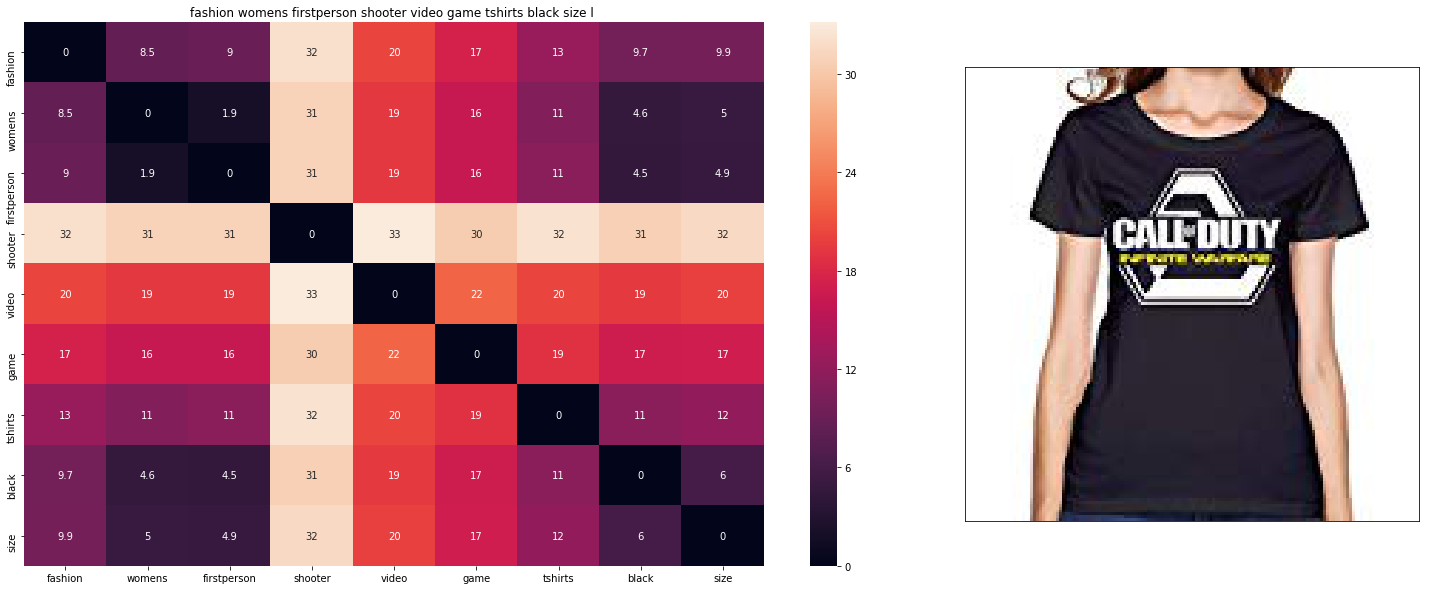

ASIN : B01INF7UVA
Brand : Aip Yep Novelty Fashion
euclidean distance from input : 0.00048828125


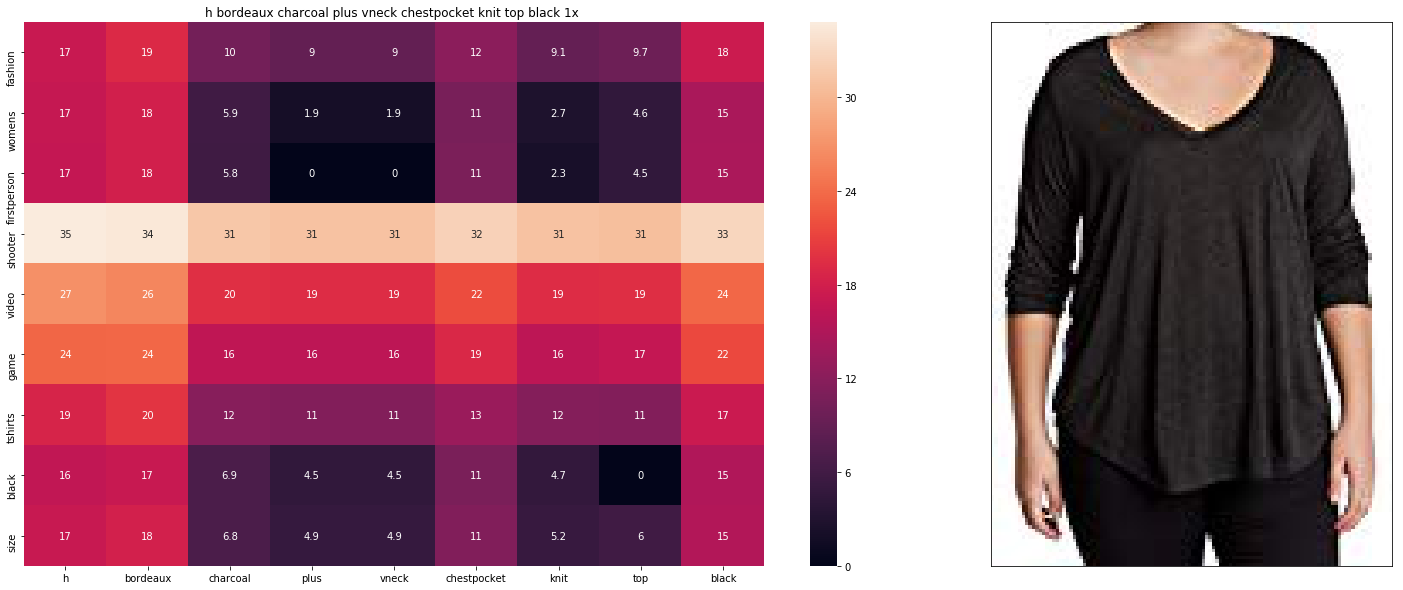

ASIN : B071HPKR6D
Brand : H By Bordeaux
euclidean distance from input : 11.41368984139648


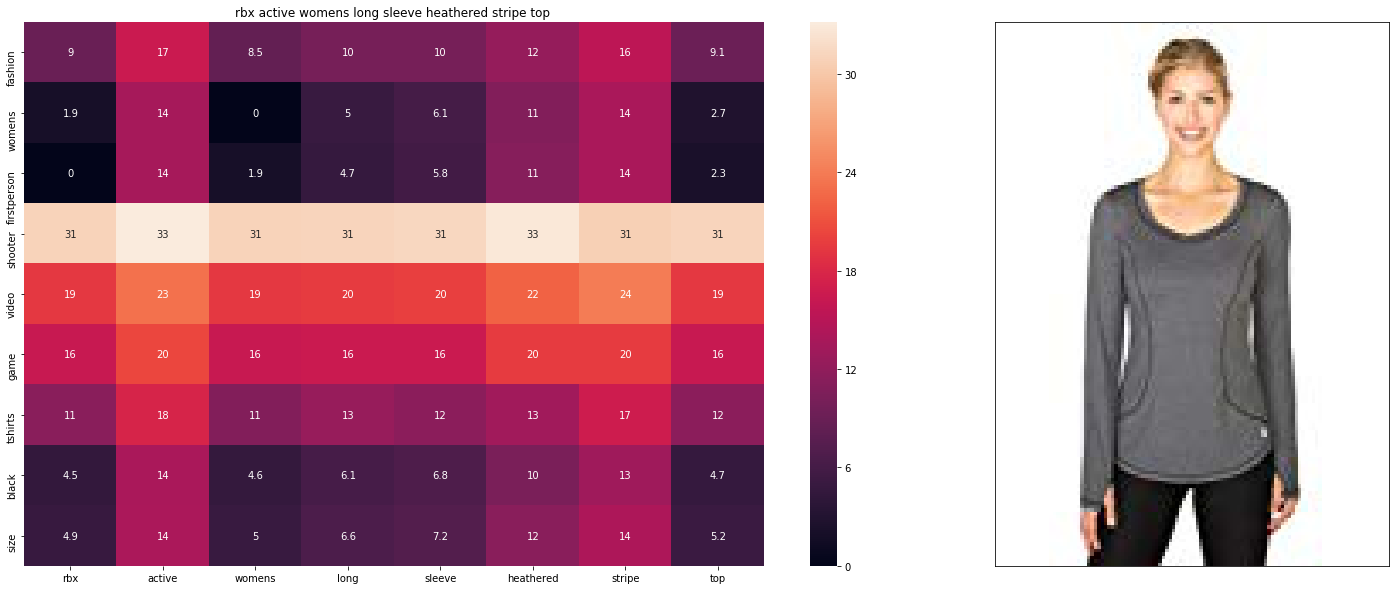

ASIN : B06XWV6FWM
Brand : RBX
euclidean distance from input : 11.616833595174509


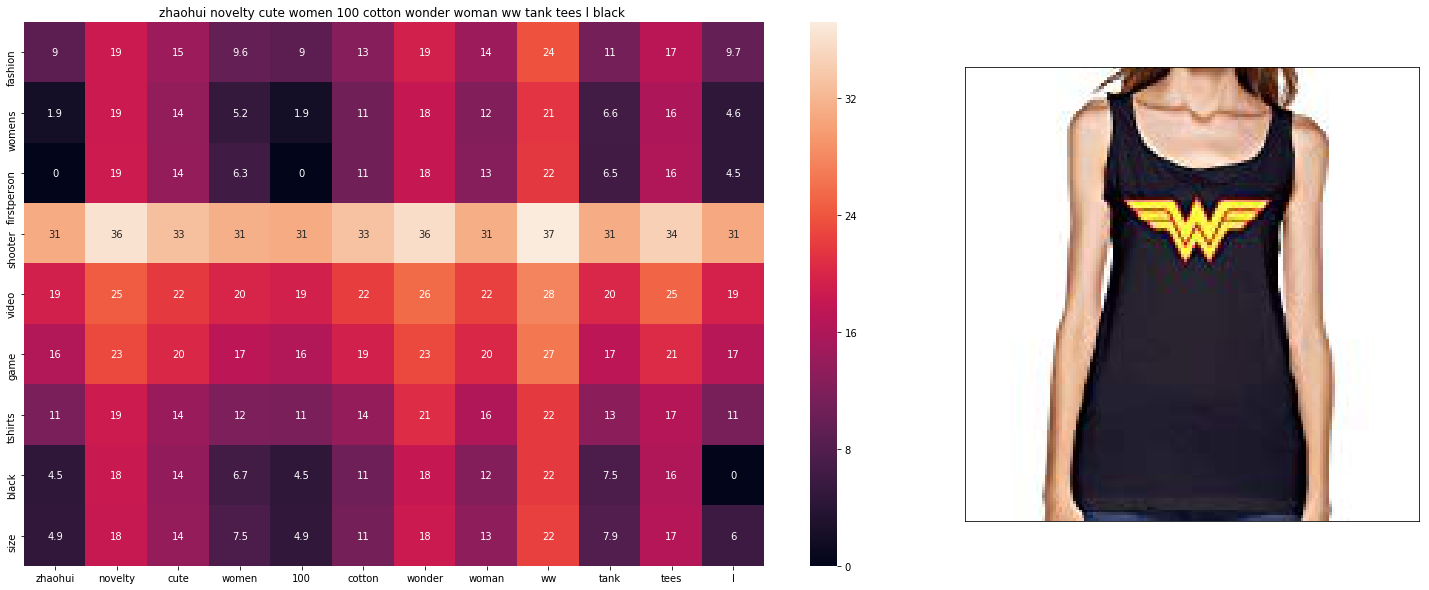

ASIN : B016OHZGZQ
Brand : ZhaoHui
euclidean distance from input : 11.666351131337837


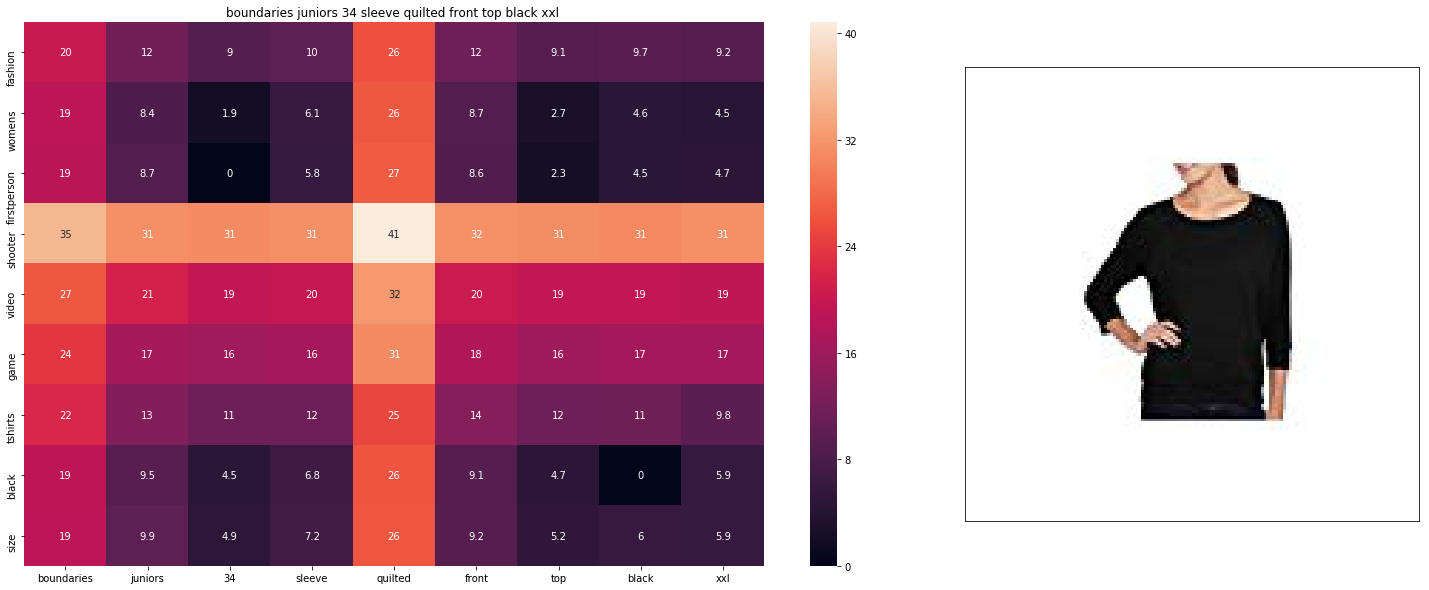

ASIN : B06XGKHC27
Brand : No Boundaries
euclidean distance from input : 11.739029063350824


In [126]:
def idf_w2v_brand(doc_id, w1, w2,w3,w4, num_results):
    # doc_id: apparel's id in given corpus
    # w1: weight for  w2v features
    # w2: weight for brand and color features

    # pairwise_dist will store the distance from given input apparel to all remaining apparels
    # the metric we used here is cosine, the coside distance is mesured as K(X, Y) = <X, Y> / (||X||*||Y||)
    # http://scikit-learn.org/stable/modules/metrics.html#cosine-similarity
    idf_w2v_dist  = pairwise_distances(w2v_title_weight, w2v_title_weight[doc_id].reshape(1,-1))
    brand_dist = pairwise_distances(extra_features, extra_features[doc_id])
    color_dist = pairwise_distances(extra_features1, extra_features1[doc_id])
    image_dist = pairwise_distances(bottleneck_features_train, bottleneck_features_train[doc_id].reshape(1,-1))
    pairwise_dist   = (w1 * idf_w2v_dist +  w2 *brand_dist +w3*color_dist+ w4*image_dist)/float(w1 + w2+w3+w4)

    # np.argsort will return indices of 20 smallest distances
    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    #pdists will store the 20 smallest distances
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]

    #data frame indices of the 20 smallest distace's
    df_indices = list(data.index[indices])
    
    for i in range(0, len(indices)):
        heat_map_w2v_brand(data['title'].loc[df_indices[0]],data['title'].loc[df_indices[i]], data['medium_image_url'].loc[df_indices[i]], indices[0], indices[i],df_indices[0], df_indices[i], 'weighted')
        print('ASIN :',data['asin'].loc[df_indices[i]])
        print('Brand :',data['brand'].loc[df_indices[i]])
        print('euclidean distance from input :', pdists[i])
        print('='*125)


    

idf_w2v_brand(1000,5,5,5,5,5)

## Checking each feature Individually

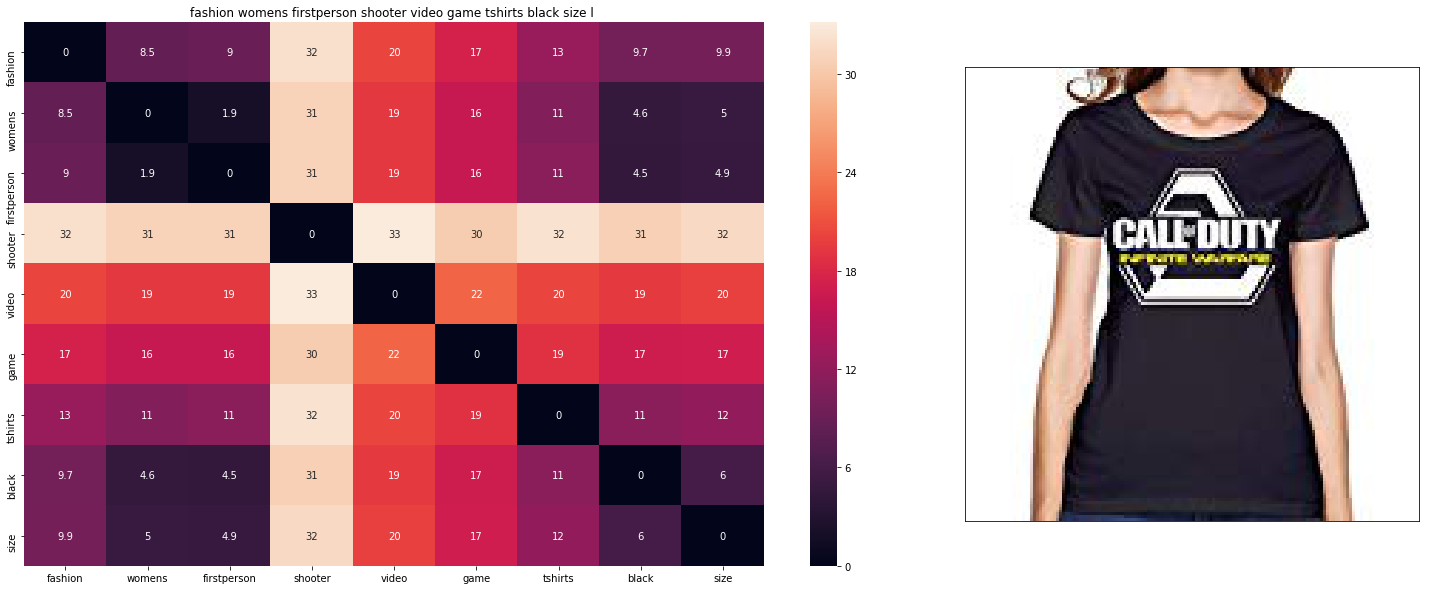

ASIN : B01INF7UVA
Brand : Aip Yep Novelty Fashion
euclidean distance from input : 0.001953125


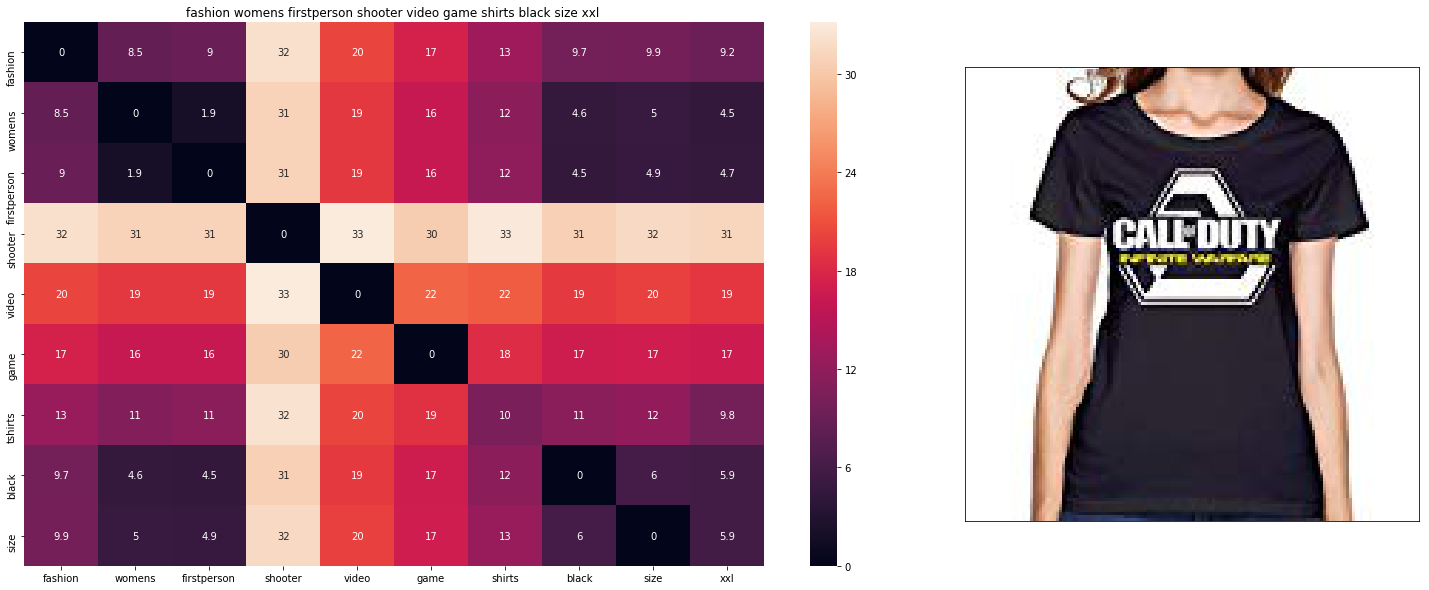

ASIN : B01INF84YM
Brand : Aip Yep Novelty Fashion
euclidean distance from input : 1.0245113372802734


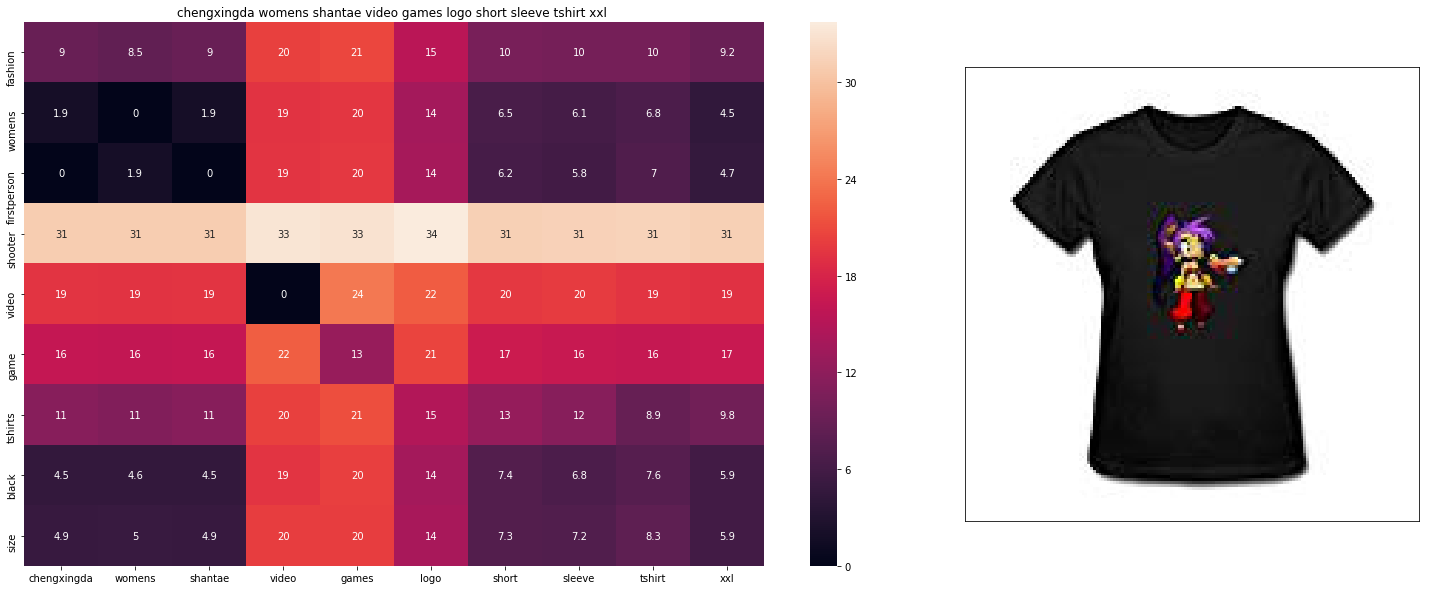

ASIN : B01IMP76XI
Brand : CHENGXINGDA
euclidean distance from input : 3.9021811485290527


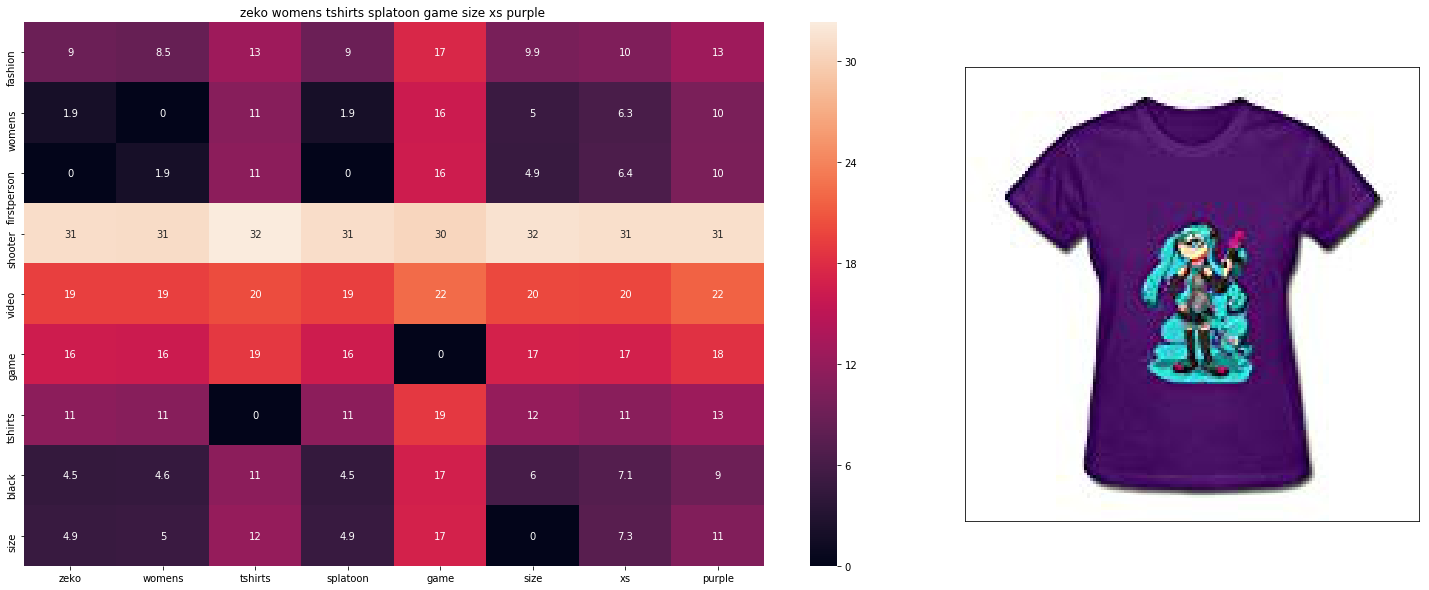

ASIN : B0167UURXQ
Brand : ZEKO
euclidean distance from input : 4.058516979217529


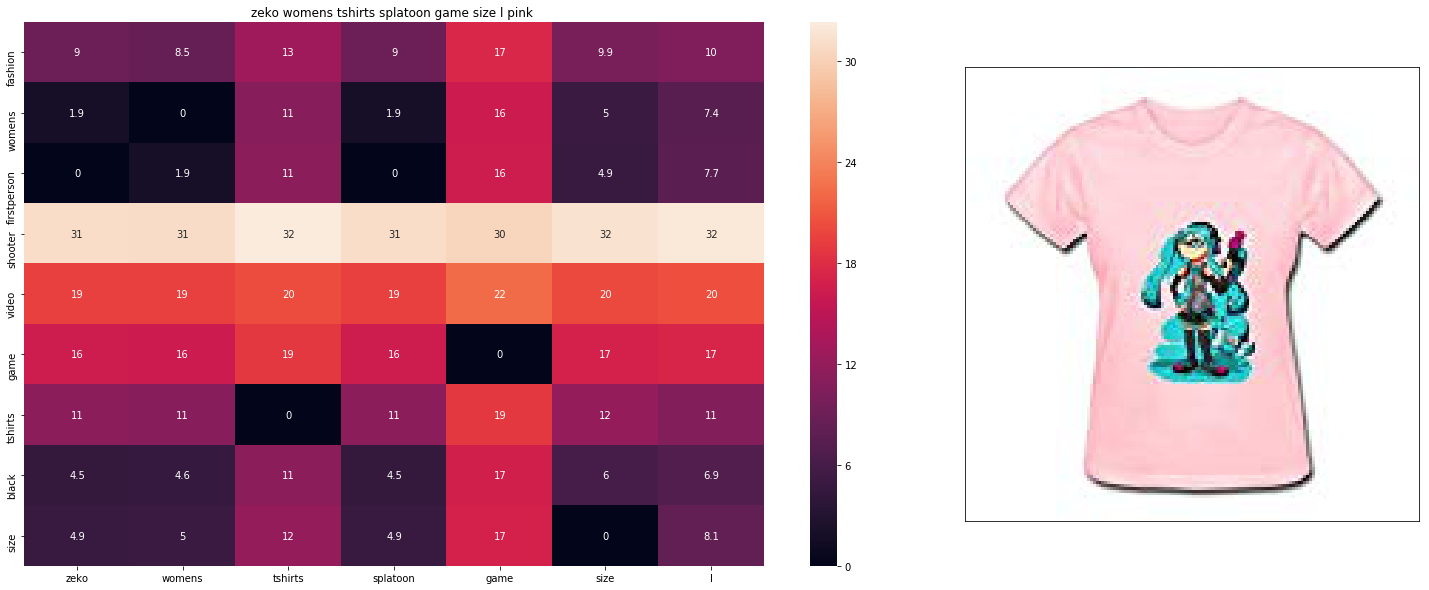

ASIN : B0167UU5ZQ
Brand : ZEKO
euclidean distance from input : 4.084577560424805


In [127]:
def idf_w2v_brand(doc_id, w1, w2,w3,w4, num_results):
    # doc_id: apparel's id in given corpus
    # w1: weight for  w2v features
    # w2: weight for brand and color features

    # pairwise_dist will store the distance from given input apparel to all remaining apparels
    # the metric we used here is cosine, the coside distance is mesured as K(X, Y) = <X, Y> / (||X||*||Y||)
    # http://scikit-learn.org/stable/modules/metrics.html#cosine-similarity
    idf_w2v_dist  = pairwise_distances(w2v_title_weight, w2v_title_weight[doc_id].reshape(1,-1))
    brand_dist = pairwise_distances(extra_features, extra_features[doc_id])
    color_dist = pairwise_distances(extra_features1, extra_features1[doc_id])
    image_dist = pairwise_distances(bottleneck_features_train, bottleneck_features_train[doc_id].reshape(1,-1))
    pairwise_dist   = (w1 * idf_w2v_dist +  w2 *brand_dist +w3*color_dist+ w4*image_dist)/float(w1 + w2+w3+w4)

    # np.argsort will return indices of 20 smallest distances
    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    #pdists will store the 20 smallest distances
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]

    #data frame indices of the 20 smallest distace's
    df_indices = list(data.index[indices])
    
    for i in range(0, len(indices)):
        heat_map_w2v_brand(data['title'].loc[df_indices[0]],data['title'].loc[df_indices[i]], data['medium_image_url'].loc[df_indices[i]], indices[0], indices[i],df_indices[0], df_indices[i], 'weighted')
        print('ASIN :',data['asin'].loc[df_indices[i]])
        print('Brand :',data['brand'].loc[df_indices[i]])
        print('euclidean distance from input :', pdists[i])
        print('='*125)


    

idf_w2v_brand(1000,1,0,0,0,5)

## Observations:
    * Using only IDF weighted w2vec we got good recommendations

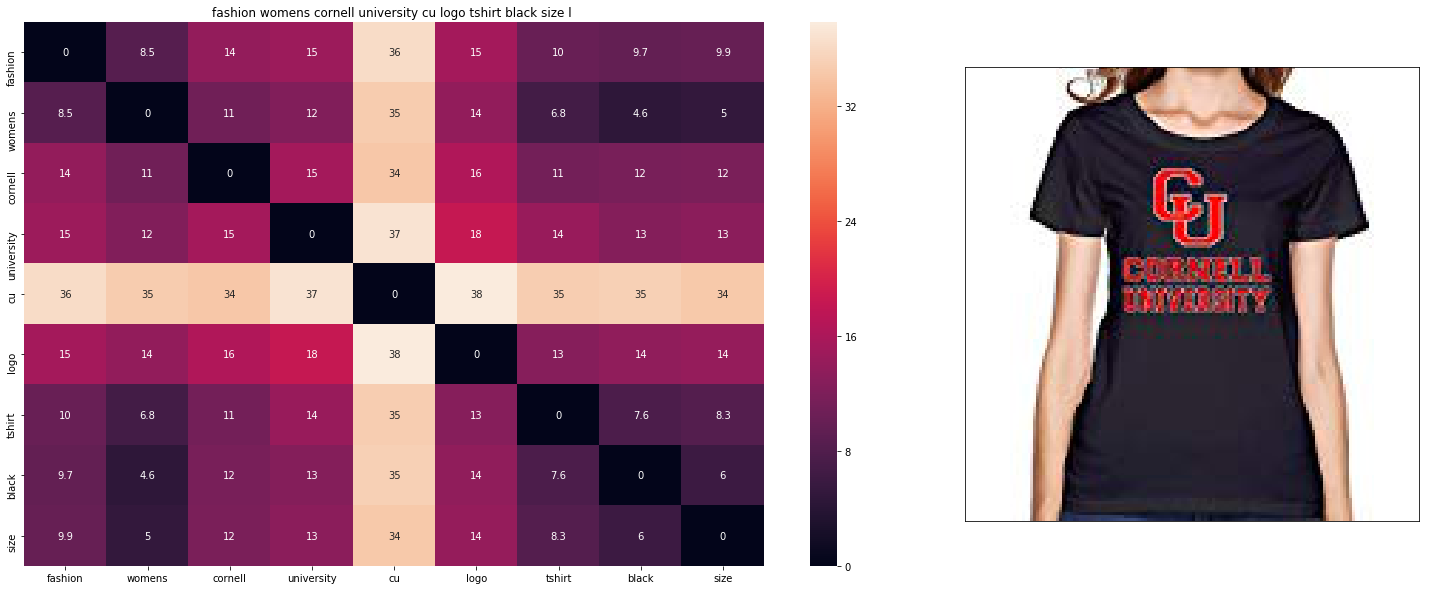

ASIN : B01IY8TDOS
Brand : Aip Yep Novelty Fashion
euclidean distance from input : 0.0


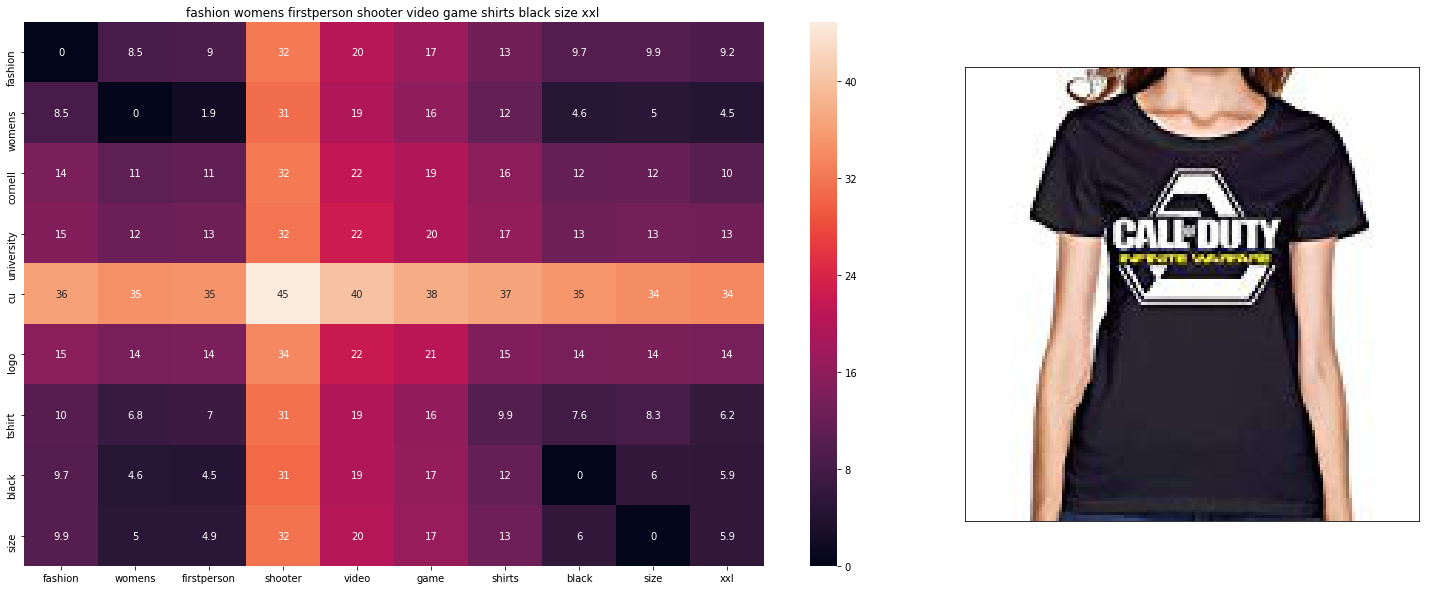

ASIN : B01INF84YM
Brand : Aip Yep Novelty Fashion
euclidean distance from input : 0.0


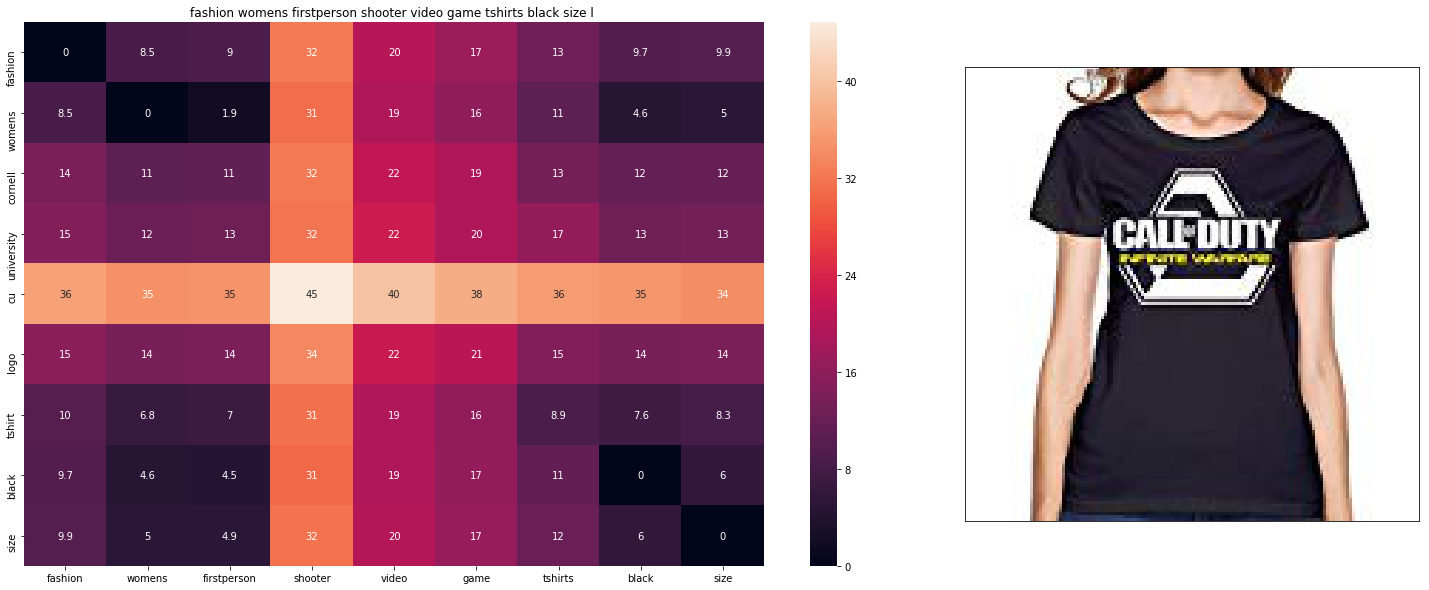

ASIN : B01INF7UVA
Brand : Aip Yep Novelty Fashion
euclidean distance from input : 0.0


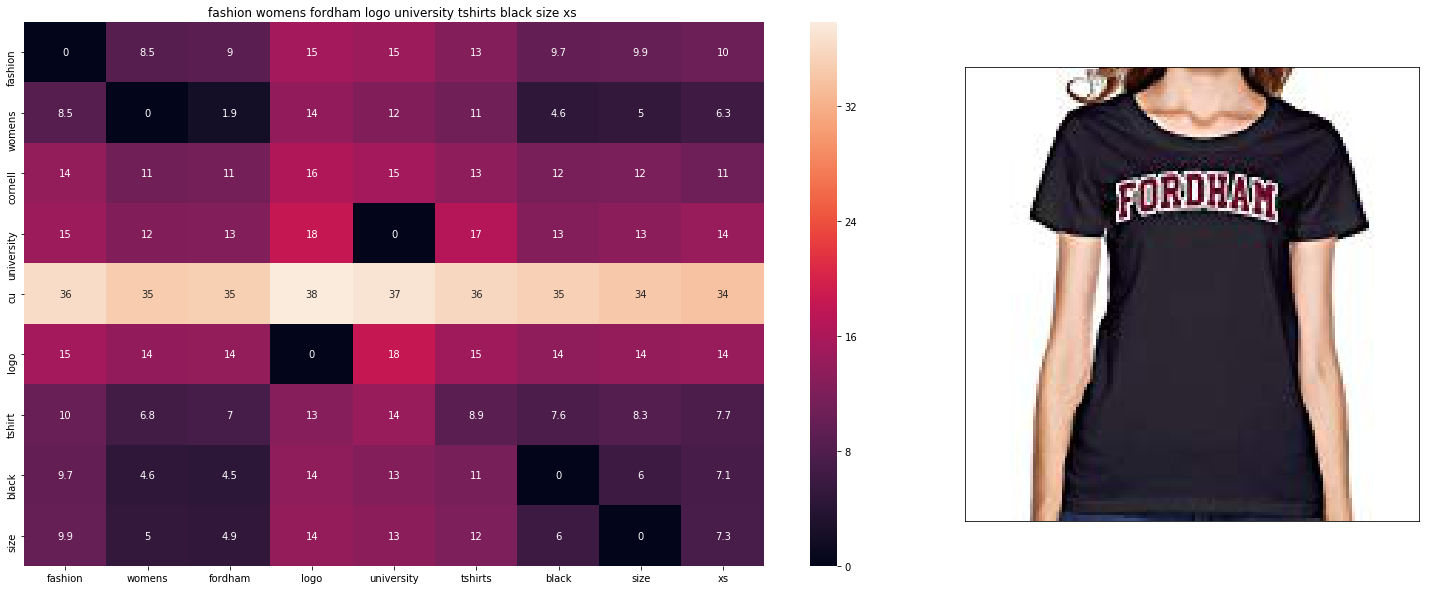

ASIN : B01IY8TTV0
Brand : Aip Yep Novelty Fashion
euclidean distance from input : 0.0


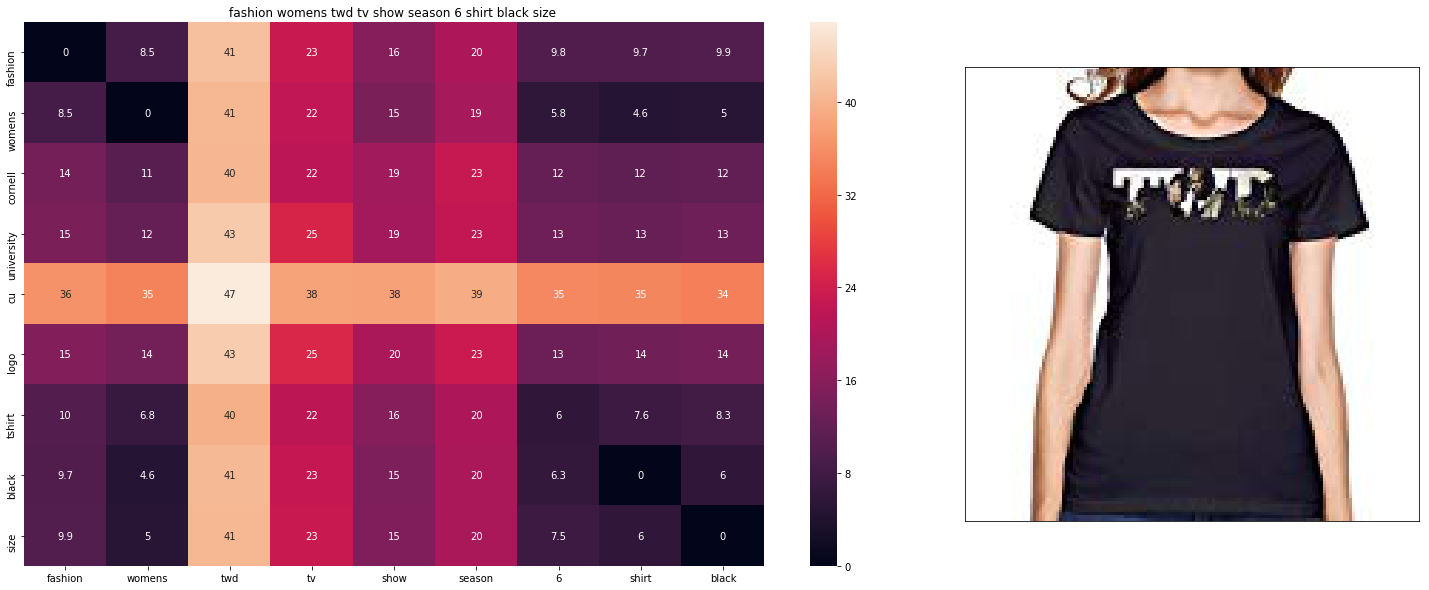

ASIN : B01IY8TOKQ
Brand : Aip Yep Novelty Fashion
euclidean distance from input : 0.0


In [128]:
def idf_w2v_brand(doc_id, w1, w2,w3,w4, num_results):
    # doc_id: apparel's id in given corpus
    # w1: weight for  w2v features
    # w2: weight for brand and color features

    # pairwise_dist will store the distance from given input apparel to all remaining apparels
    # the metric we used here is cosine, the coside distance is mesured as K(X, Y) = <X, Y> / (||X||*||Y||)
    # http://scikit-learn.org/stable/modules/metrics.html#cosine-similarity
    idf_w2v_dist  = pairwise_distances(w2v_title_weight, w2v_title_weight[doc_id].reshape(1,-1))
    brand_dist = pairwise_distances(extra_features, extra_features[doc_id])
    color_dist = pairwise_distances(extra_features1, extra_features1[doc_id])
    image_dist = pairwise_distances(bottleneck_features_train, bottleneck_features_train[doc_id].reshape(1,-1))
    pairwise_dist   = (w1 * idf_w2v_dist +  w2 *brand_dist +w3*color_dist+ w4*image_dist)/float(w1 + w2+w3+w4)

    # np.argsort will return indices of 20 smallest distances
    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    #pdists will store the 20 smallest distances
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]

    #data frame indices of the 20 smallest distace's
    df_indices = list(data.index[indices])
    
    for i in range(0, len(indices)):
        heat_map_w2v_brand(data['title'].loc[df_indices[0]],data['title'].loc[df_indices[i]], data['medium_image_url'].loc[df_indices[i]], indices[0], indices[i],df_indices[0], df_indices[i], 'weighted')
        print('ASIN :',data['asin'].loc[df_indices[i]])
        print('Brand :',data['brand'].loc[df_indices[i]])
        print('euclidean distance from input :', pdists[i])
        print('='*125)


    

idf_w2v_brand(1000,0,1,0,0,5)

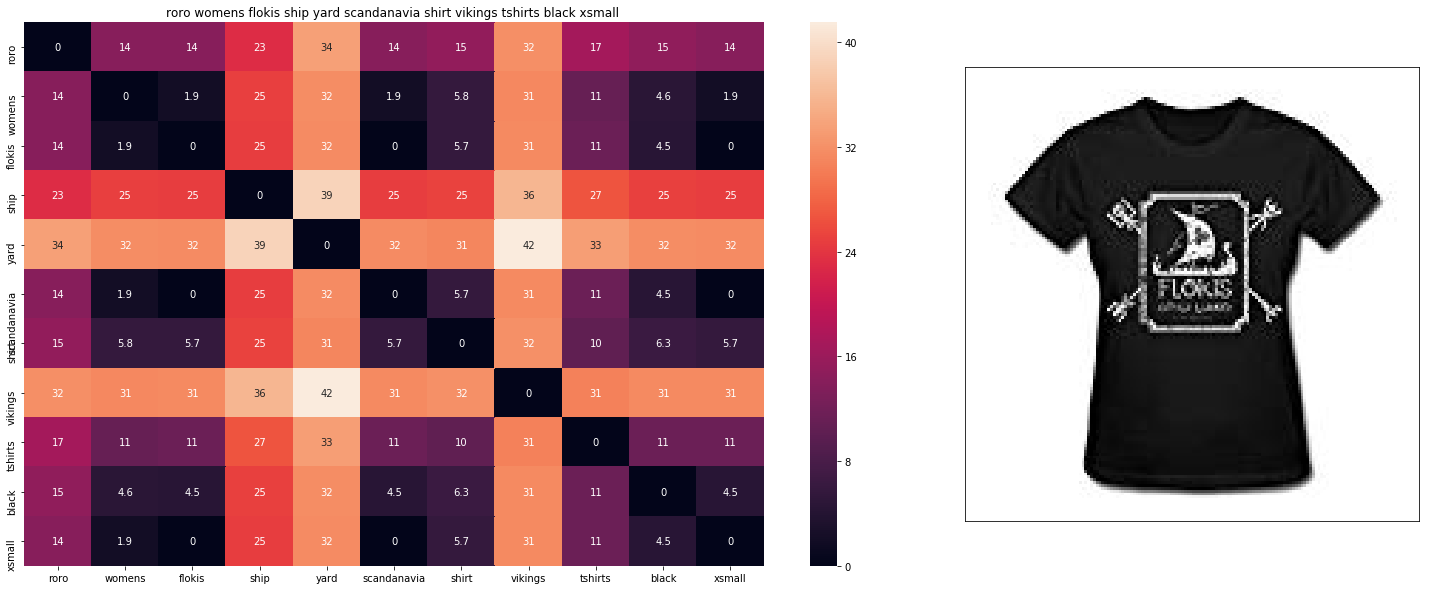

ASIN : B01BFAUDVO
Brand : roro
euclidean distance from input : 0.0


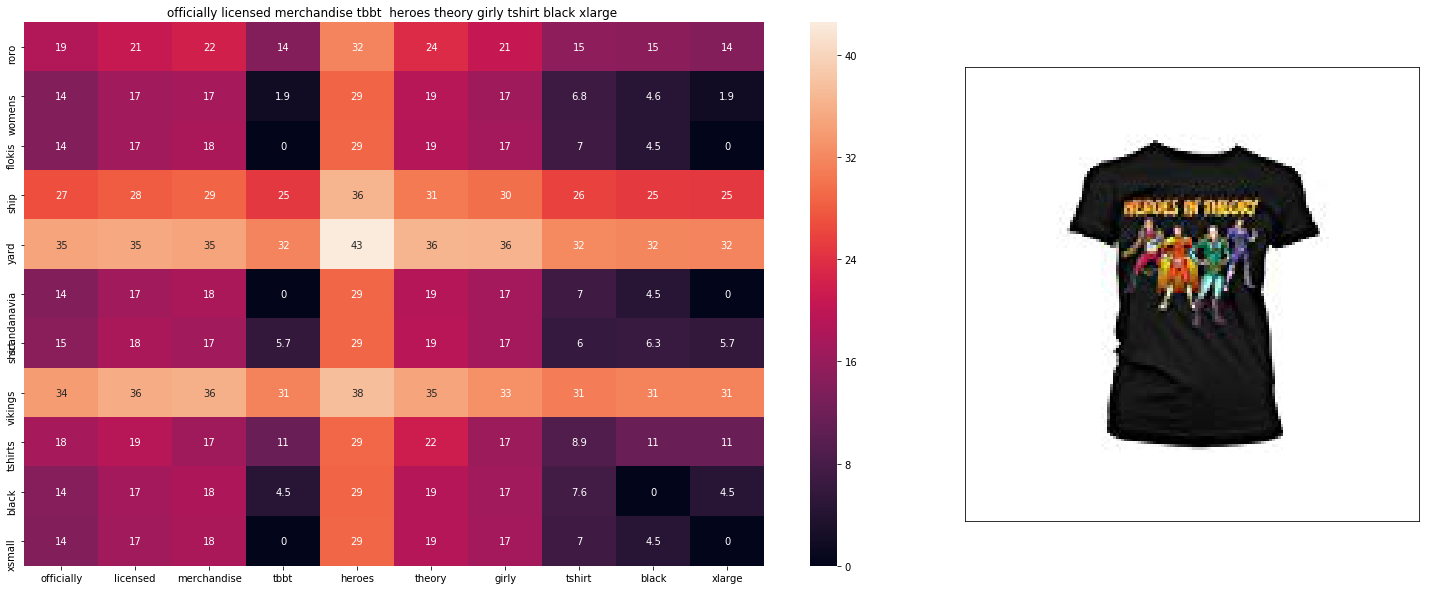

ASIN : B01BFLGCX6
Brand : The Big Bang Theory
euclidean distance from input : 0.0


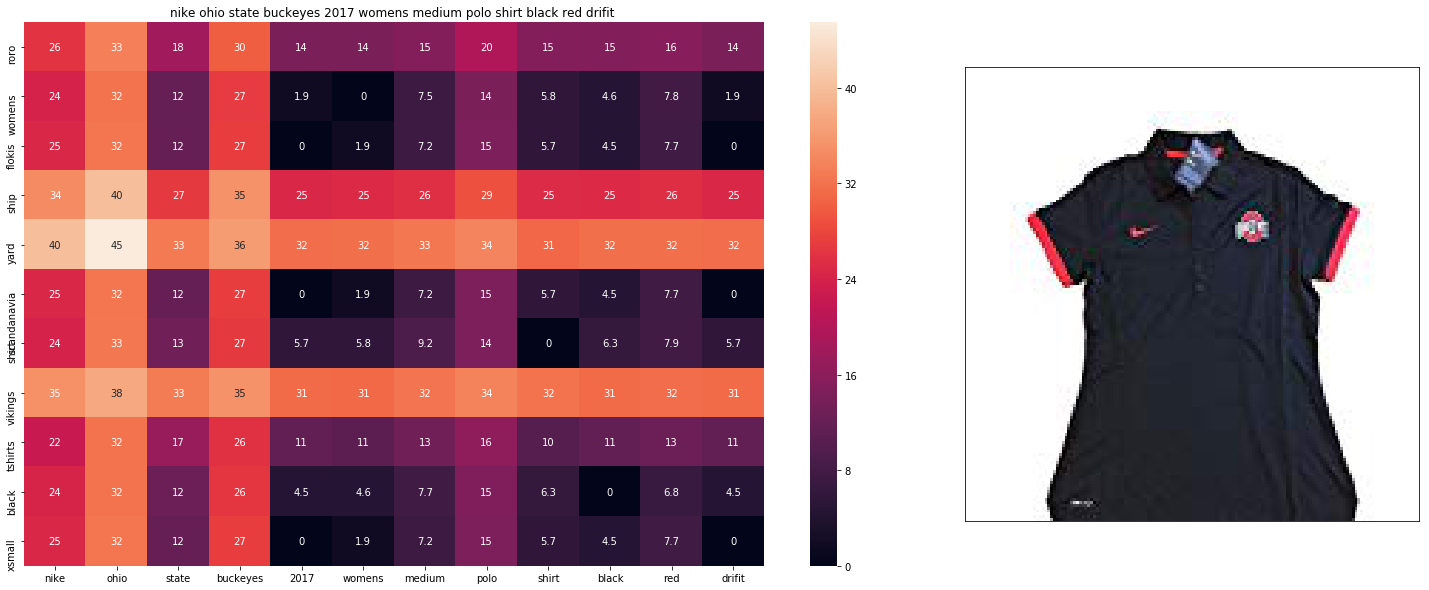

ASIN : B01N4JMS11
Brand : NIKE
euclidean distance from input : 0.0


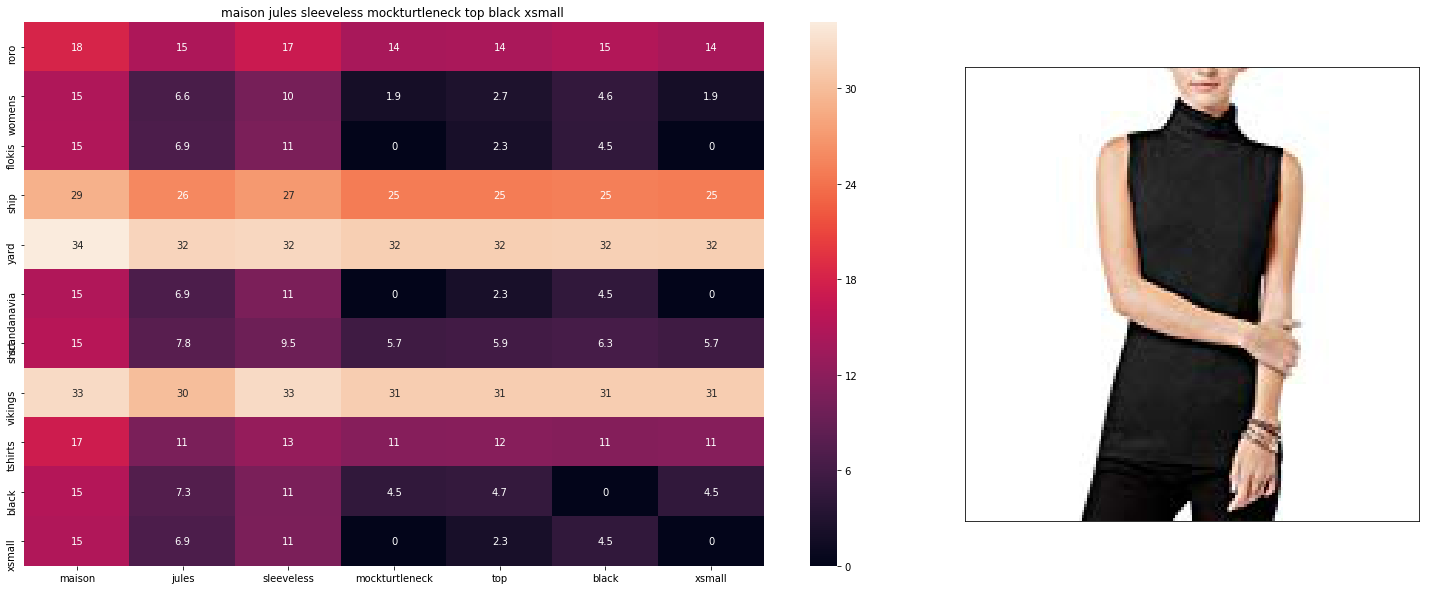

ASIN : B0753JRGTG
Brand : Maison Jules
euclidean distance from input : 0.0


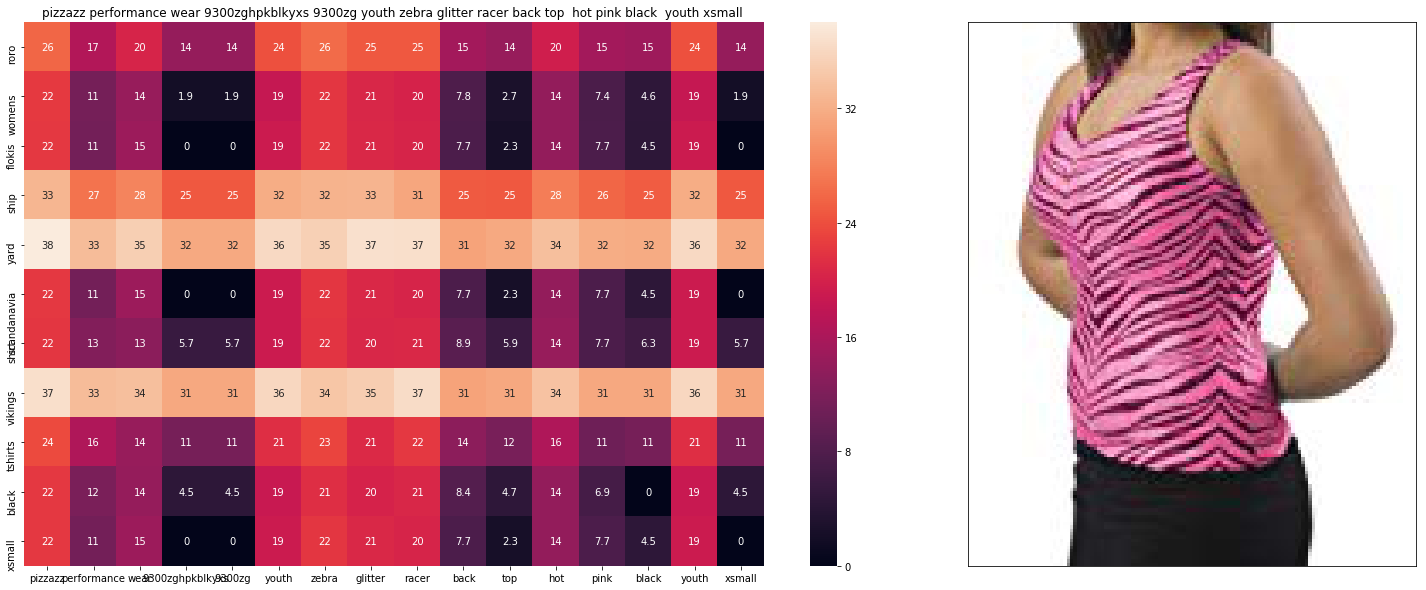

ASIN : B00A2HEADE
Brand : Not given
euclidean distance from input : 0.0


In [130]:
def idf_w2v_brand(doc_id, w1, w2,w3,w4, num_results):
    # doc_id: apparel's id in given corpus
    # w1: weight for  w2v features
    # w2: weight for brand and color features

    # pairwise_dist will store the distance from given input apparel to all remaining apparels
    # the metric we used here is cosine, the coside distance is mesured as K(X, Y) = <X, Y> / (||X||*||Y||)
    # http://scikit-learn.org/stable/modules/metrics.html#cosine-similarity
    idf_w2v_dist  = pairwise_distances(w2v_title_weight, w2v_title_weight[doc_id].reshape(1,-1))
    brand_dist = pairwise_distances(extra_features, extra_features[doc_id])
    color_dist = pairwise_distances(extra_features1, extra_features1[doc_id])
    image_dist = pairwise_distances(bottleneck_features_train, bottleneck_features_train[doc_id].reshape(1,-1))
    pairwise_dist   = (w1 * idf_w2v_dist +  w2 *brand_dist +w3*color_dist+ w4*image_dist)/float(w1 + w2+w3+w4)

    # np.argsort will return indices of 20 smallest distances
    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    #pdists will store the 20 smallest distances
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]

    #data frame indices of the 20 smallest distace's
    df_indices = list(data.index[indices])
    
    for i in range(0, len(indices)):
        heat_map_w2v_brand(data['title'].loc[df_indices[0]],data['title'].loc[df_indices[i]], data['medium_image_url'].loc[df_indices[i]], indices[0], indices[i],df_indices[0], df_indices[i], 'weighted')
        print('ASIN :',data['asin'].loc[df_indices[i]])
        print('Brand :',data['brand'].loc[df_indices[i]])
        print('euclidean distance from input :', pdists[i])
        print('='*125)


    

idf_w2v_brand(1000,0,0,1,0,5)

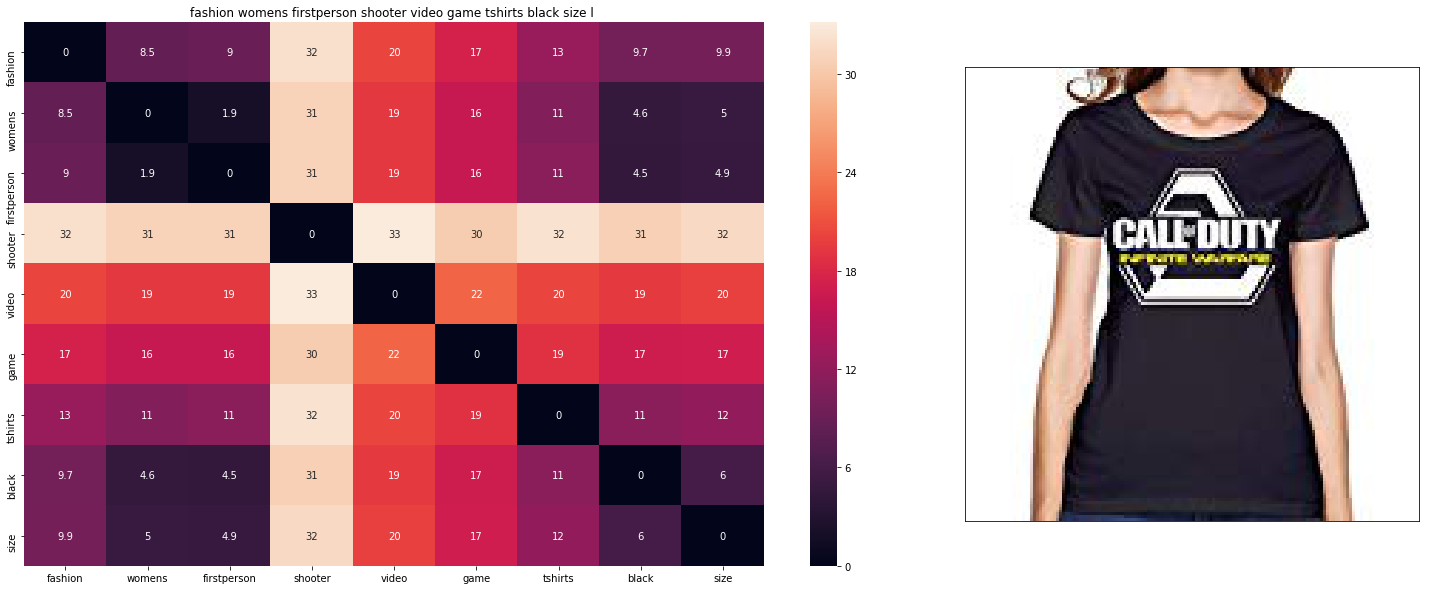

ASIN : B01INF7UVA
Brand : Aip Yep Novelty Fashion
euclidean distance from input : 0.0


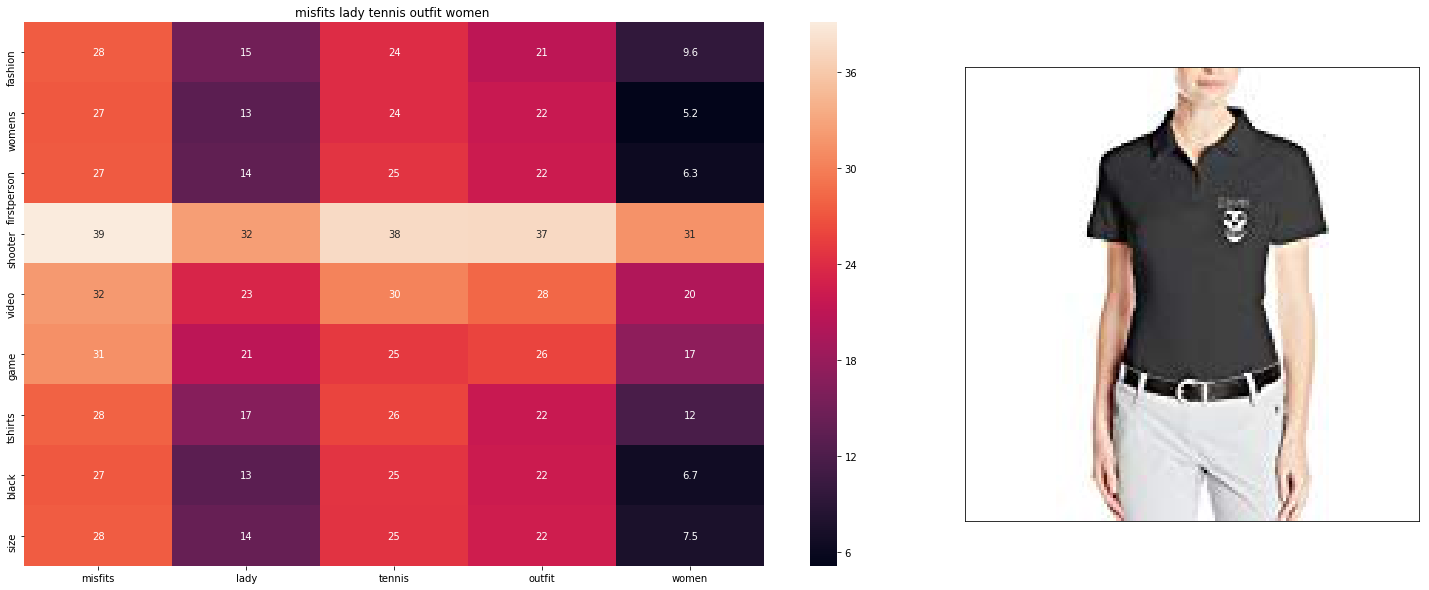

ASIN : B01FHKJEBI
Brand : zhoujie
euclidean distance from input : 34.833351135253906


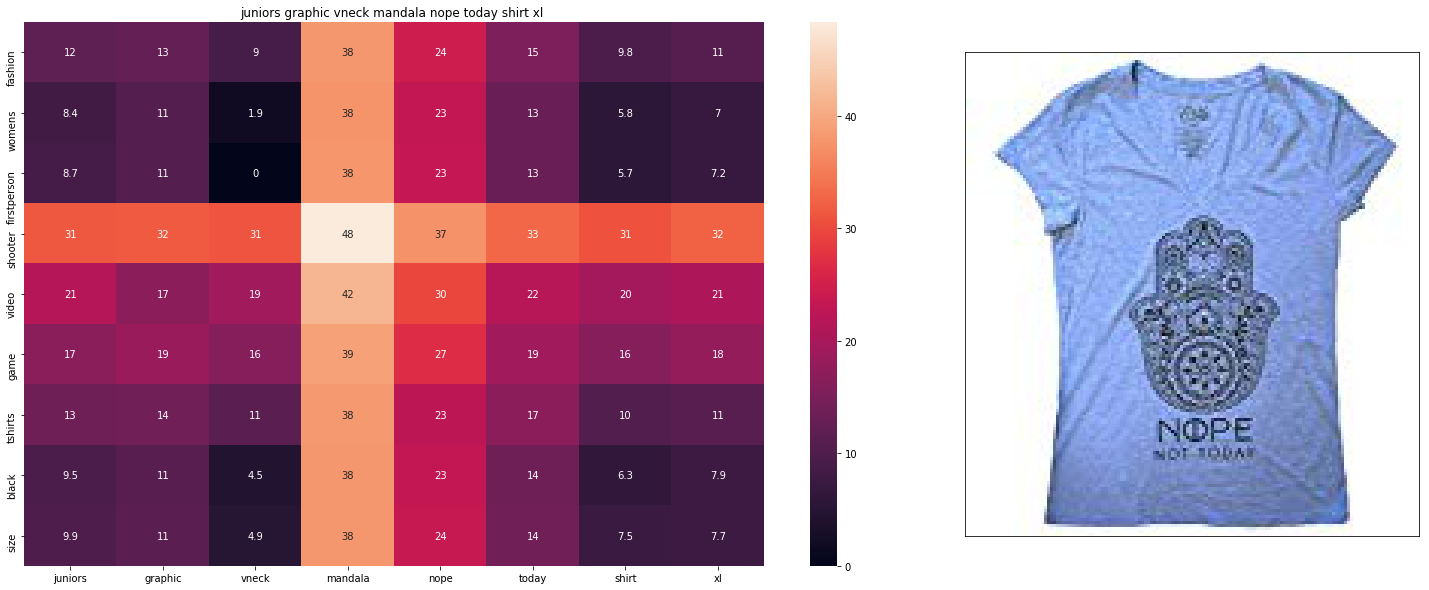

ASIN : B0735FGKSD
Brand : Cold Crush
euclidean distance from input : 36.06010437011719


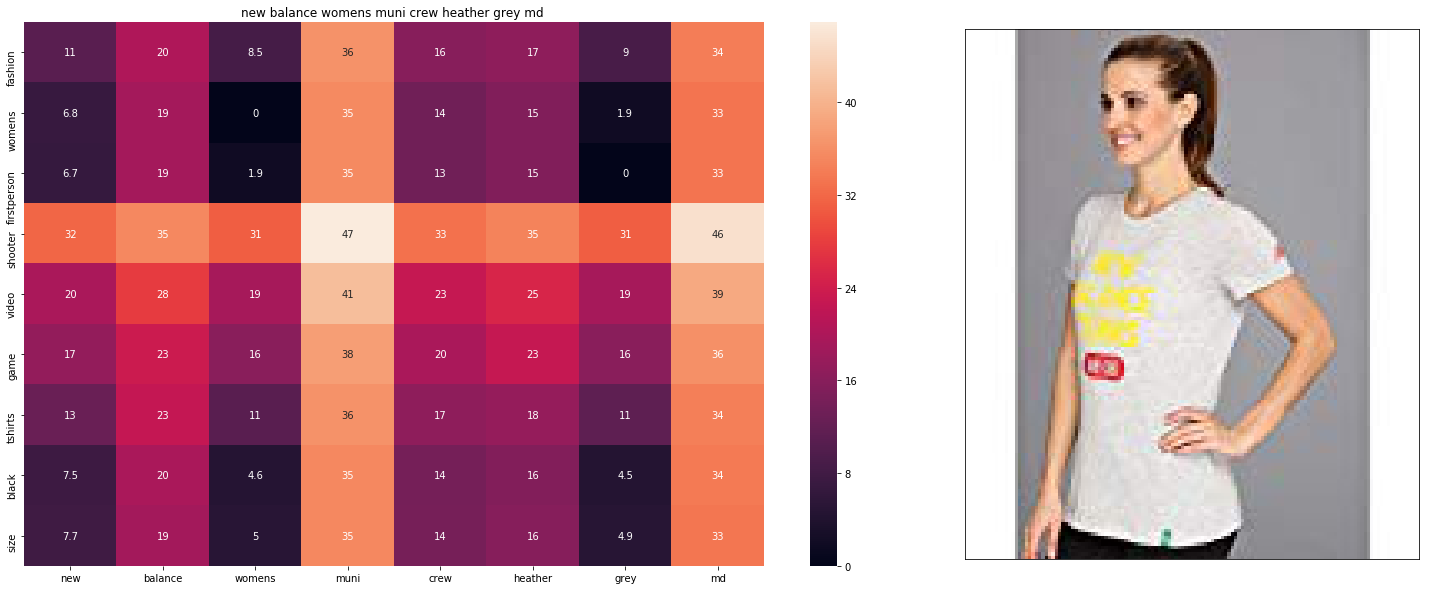

ASIN : B00G0FSP1U
Brand : New Balance
euclidean distance from input : 36.64521789550781


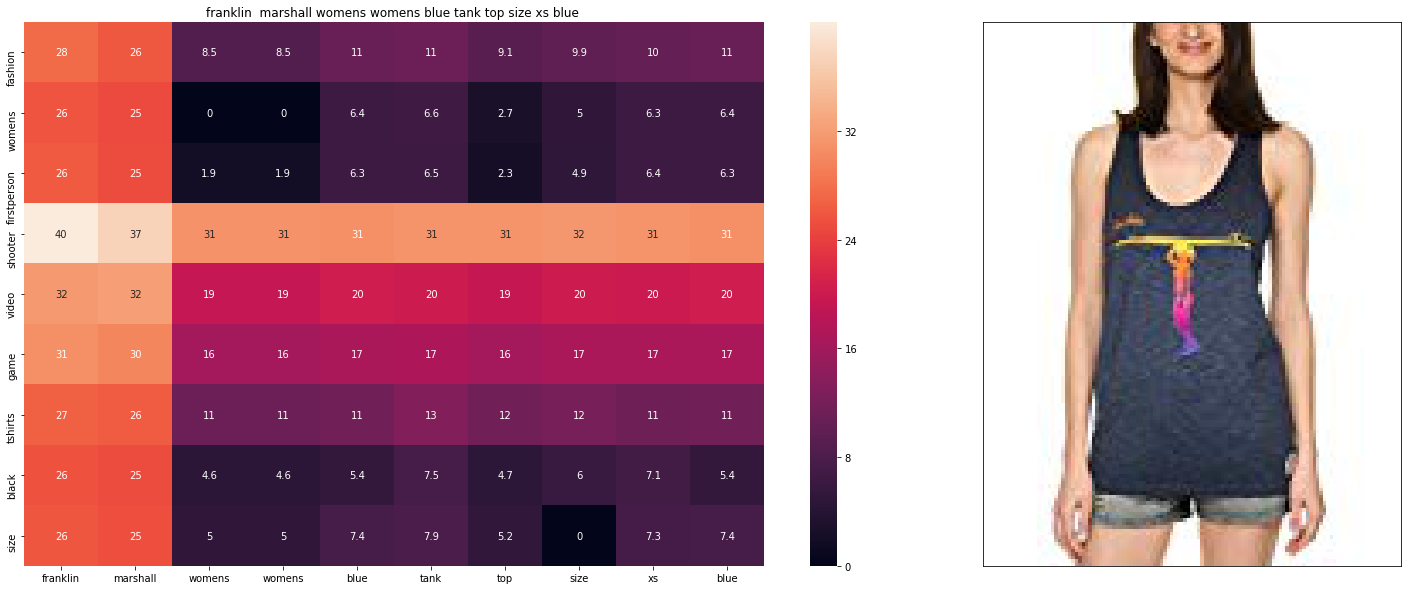

ASIN : B06Y41WQS4
Brand : Franklin & Marshall
euclidean distance from input : 36.875755310058594


In [131]:
def idf_w2v_brand(doc_id, w1, w2,w3,w4, num_results):
    # doc_id: apparel's id in given corpus
    # w1: weight for  w2v features
    # w2: weight for brand and color features

    # pairwise_dist will store the distance from given input apparel to all remaining apparels
    # the metric we used here is cosine, the coside distance is mesured as K(X, Y) = <X, Y> / (||X||*||Y||)
    # http://scikit-learn.org/stable/modules/metrics.html#cosine-similarity
    idf_w2v_dist  = pairwise_distances(w2v_title_weight, w2v_title_weight[doc_id].reshape(1,-1))
    brand_dist = pairwise_distances(extra_features, extra_features[doc_id])
    color_dist = pairwise_distances(extra_features1, extra_features1[doc_id])
    image_dist = pairwise_distances(bottleneck_features_train, bottleneck_features_train[doc_id].reshape(1,-1))
    pairwise_dist   = (w1 * idf_w2v_dist +  w2 *brand_dist +w3*color_dist+ w4*image_dist)/float(w1 + w2+w3+w4)

    # np.argsort will return indices of 20 smallest distances
    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    #pdists will store the 20 smallest distances
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]

    #data frame indices of the 20 smallest distace's
    df_indices = list(data.index[indices])
    
    for i in range(0, len(indices)):
        heat_map_w2v_brand(data['title'].loc[df_indices[0]],data['title'].loc[df_indices[i]], data['medium_image_url'].loc[df_indices[i]], indices[0], indices[i],df_indices[0], df_indices[i], 'weighted')
        print('ASIN :',data['asin'].loc[df_indices[i]])
        print('Brand :',data['brand'].loc[df_indices[i]])
        print('euclidean distance from input :', pdists[i])
        print('='*125)


    

idf_w2v_brand(1000,0,0,0,1,5)

## Observations : 
    * IDF weighted word2vec seems to be giving better recommendations

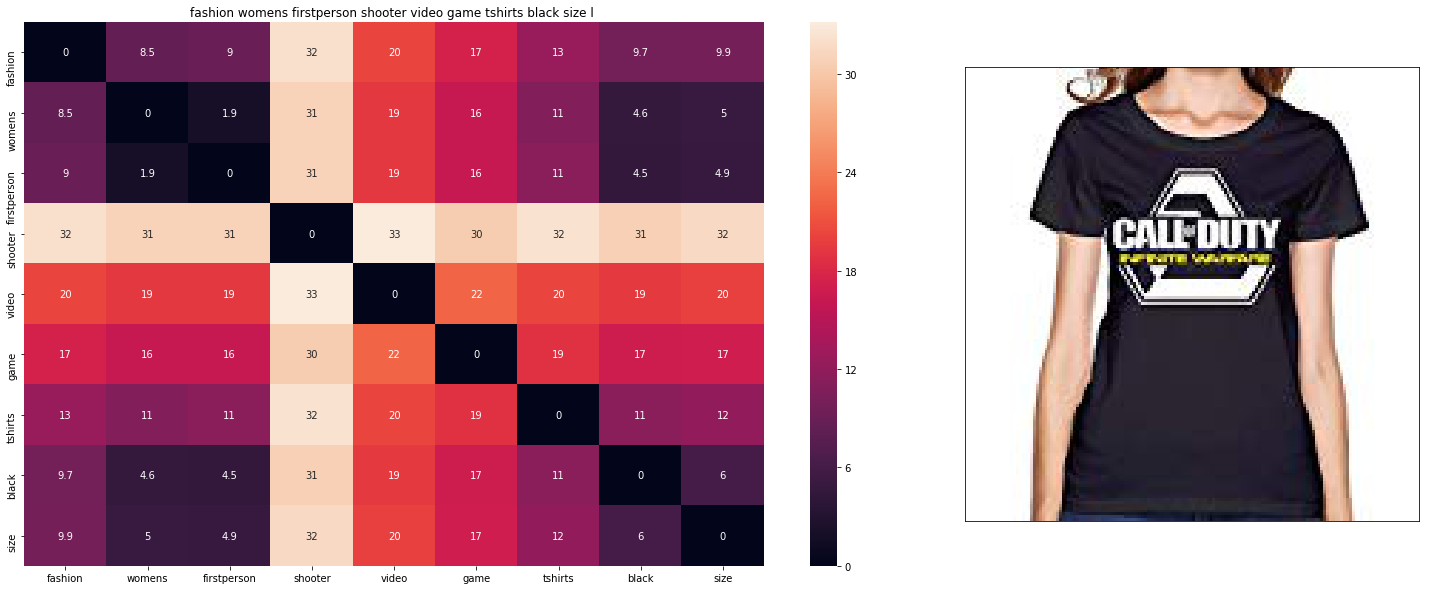

ASIN : B01INF7UVA
Brand : Aip Yep Novelty Fashion
euclidean distance from input : 0.001220703125


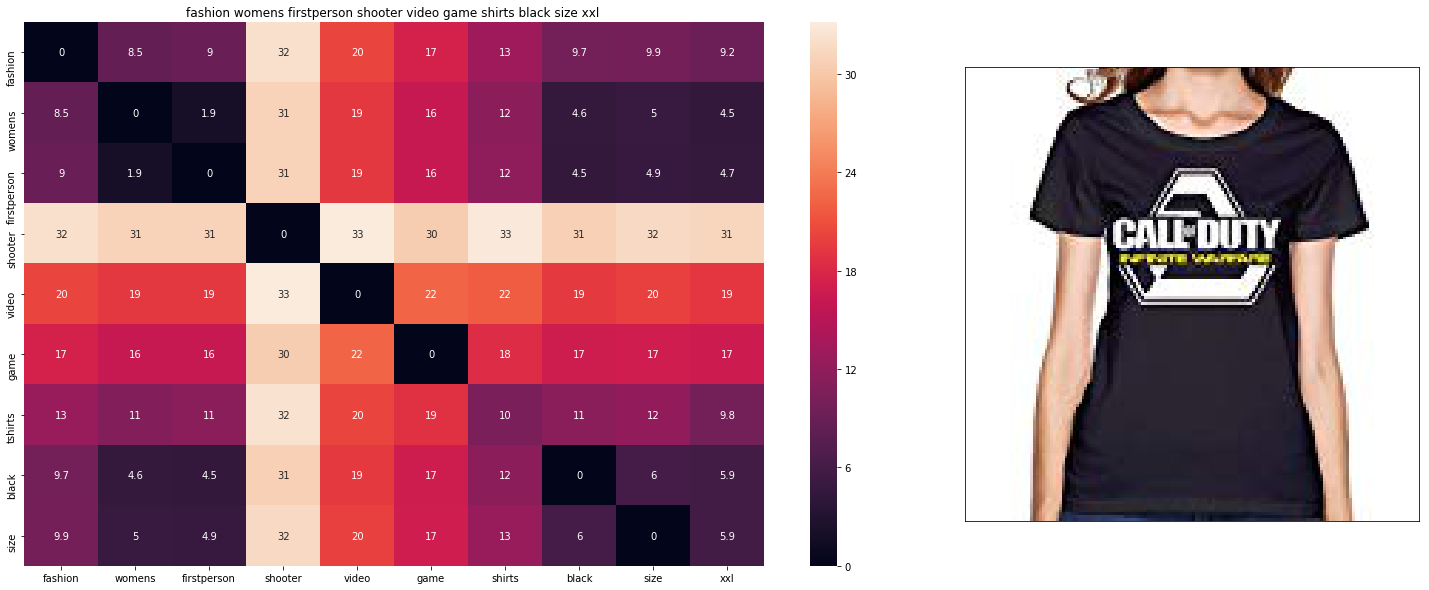

ASIN : B01INF84YM
Brand : Aip Yep Novelty Fashion
euclidean distance from input : 7.800715684890747


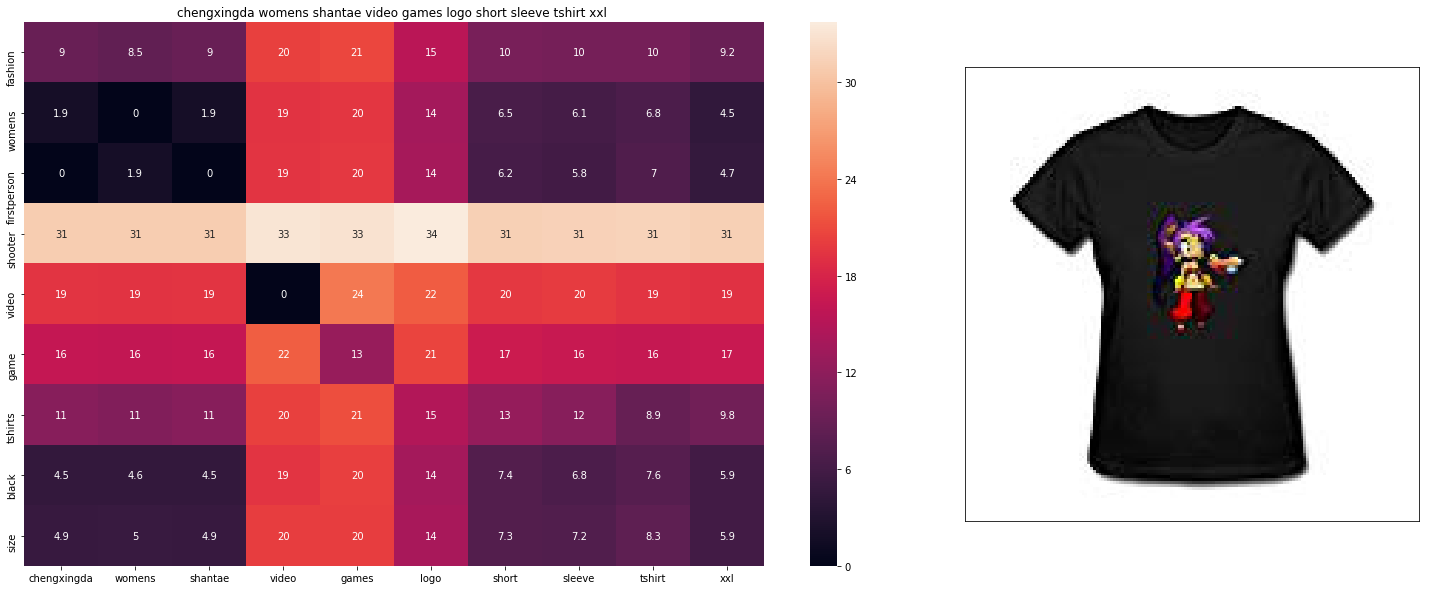

ASIN : B01IMP76XI
Brand : CHENGXINGDA
euclidean distance from input : 8.52260961718259


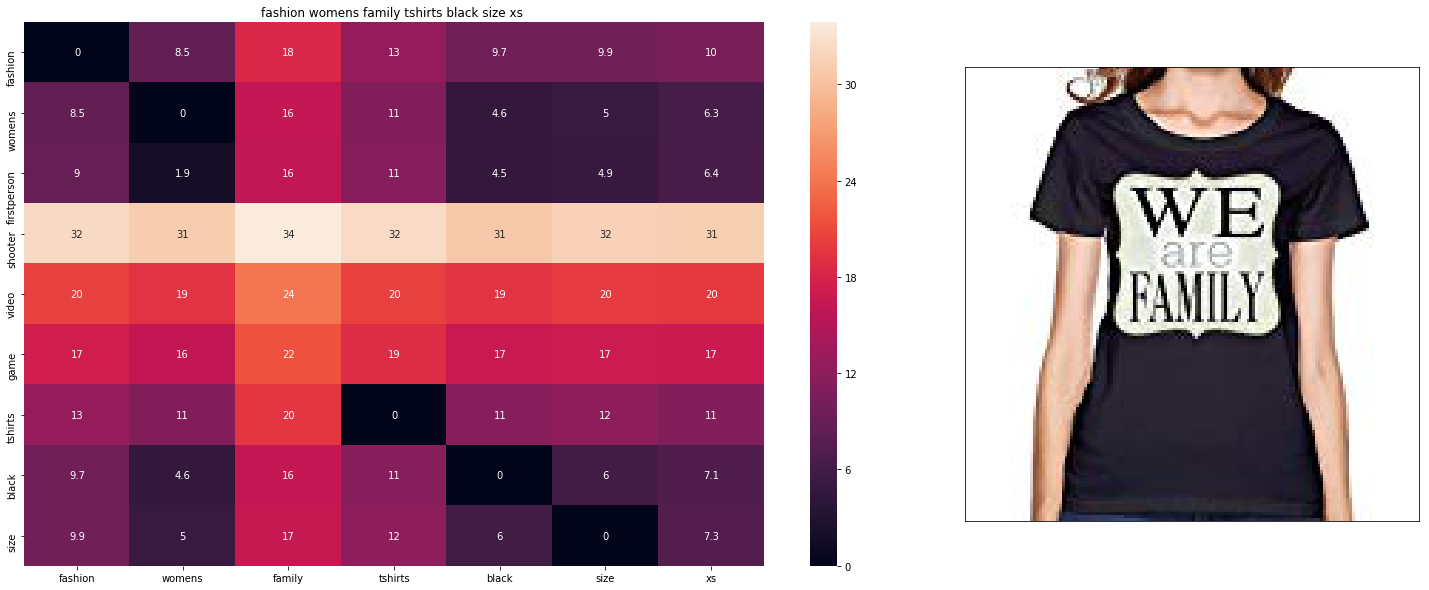

ASIN : B01IY8UHMA
Brand : Aip Yep Novelty Fashion
euclidean distance from input : 8.55446171760559


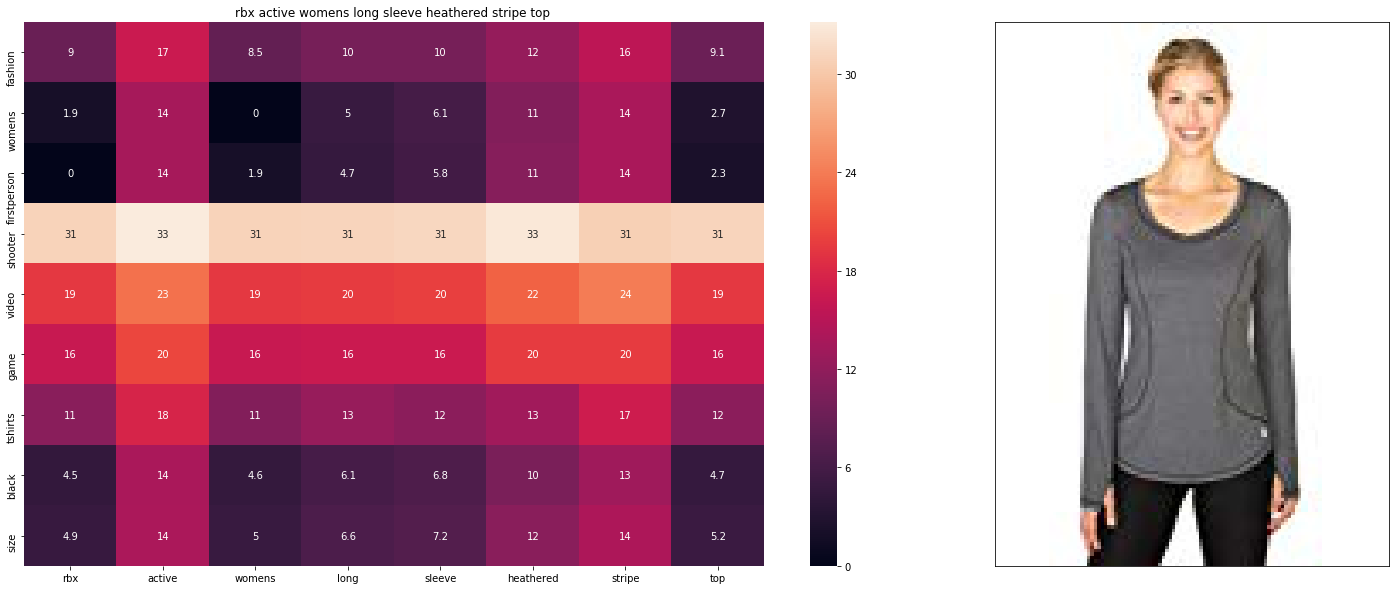

ASIN : B06XWV6FWM
Brand : RBX
euclidean distance from input : 8.589974071452


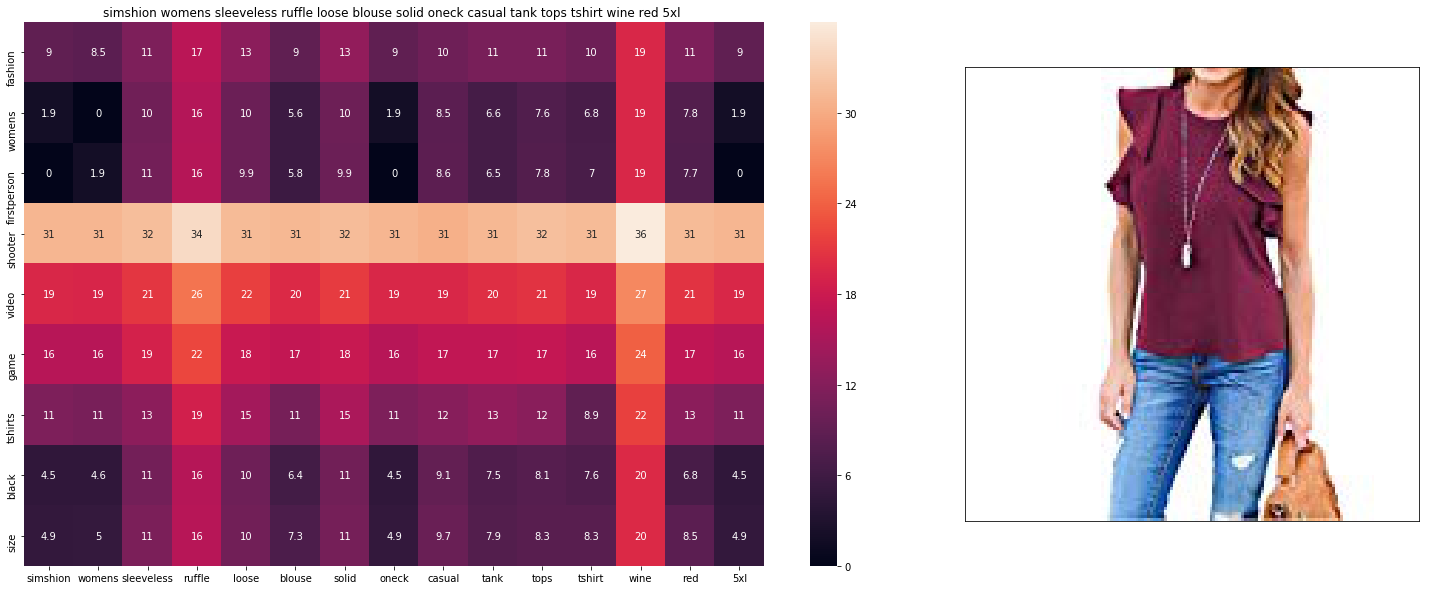

ASIN : B072QS773R
Brand : SIMSHION
euclidean distance from input : 8.590727105518837


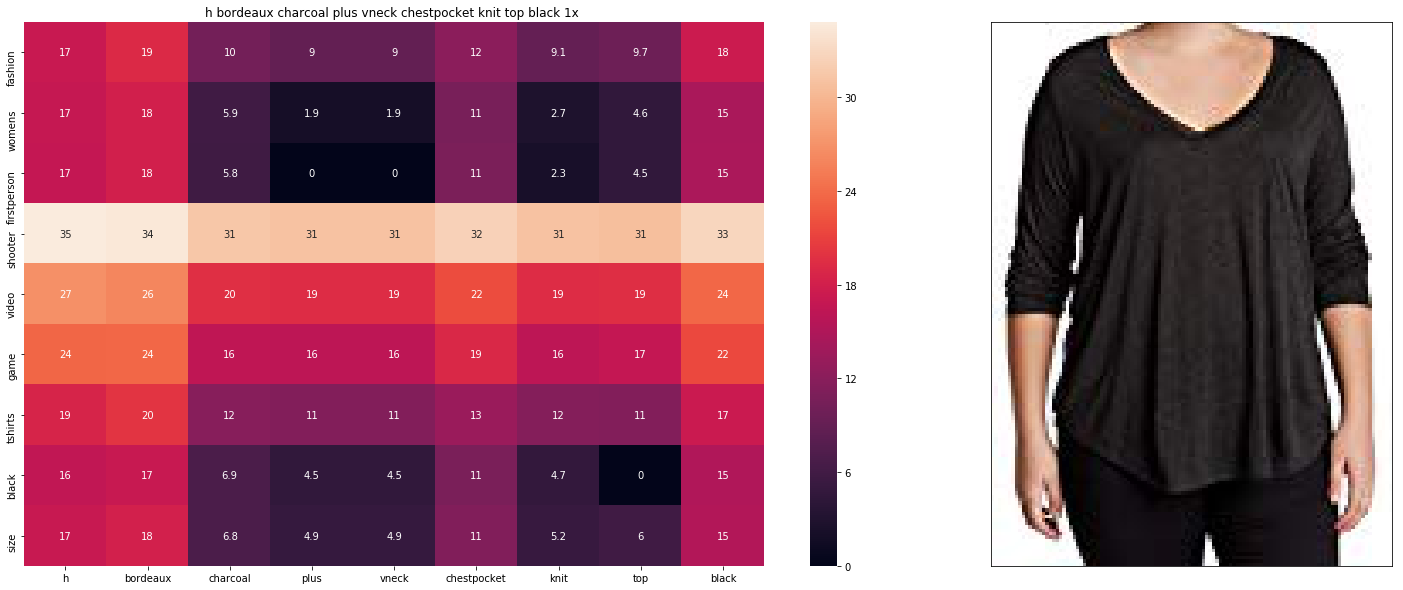

ASIN : B071HPKR6D
Brand : H By Bordeaux
euclidean distance from input : 8.640978354993894


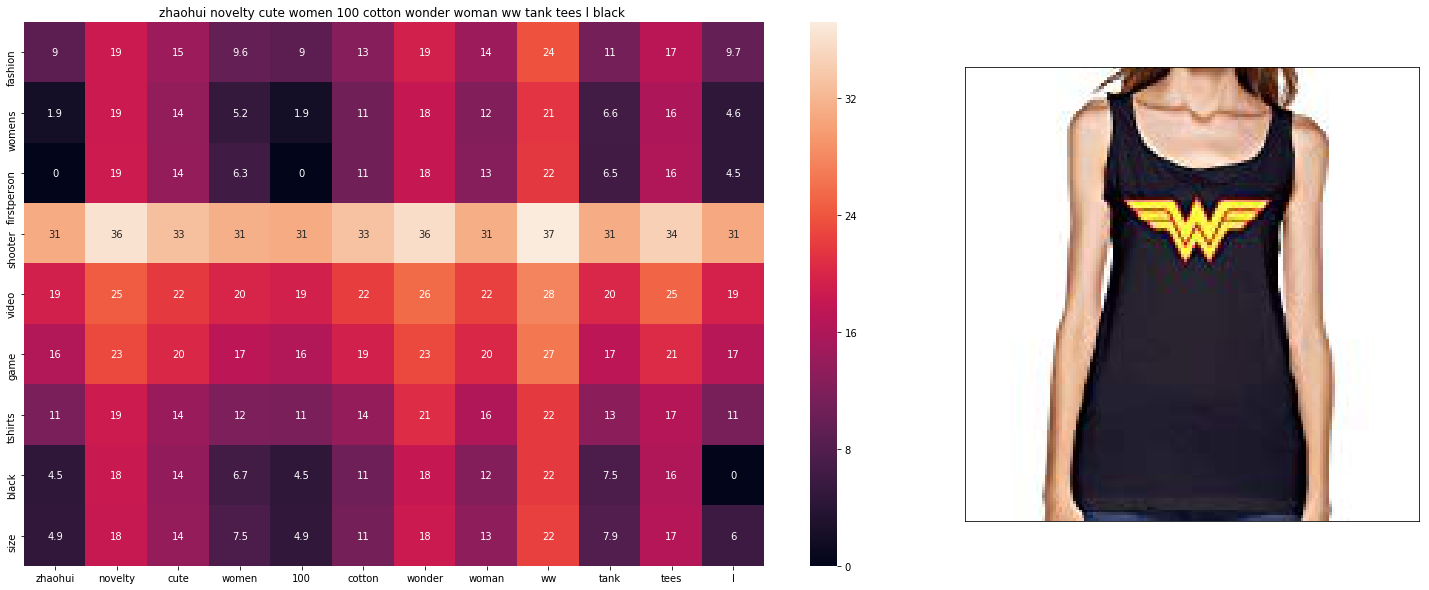

ASIN : B016OHZGZQ
Brand : ZhaoHui
euclidean distance from input : 8.641975309321262


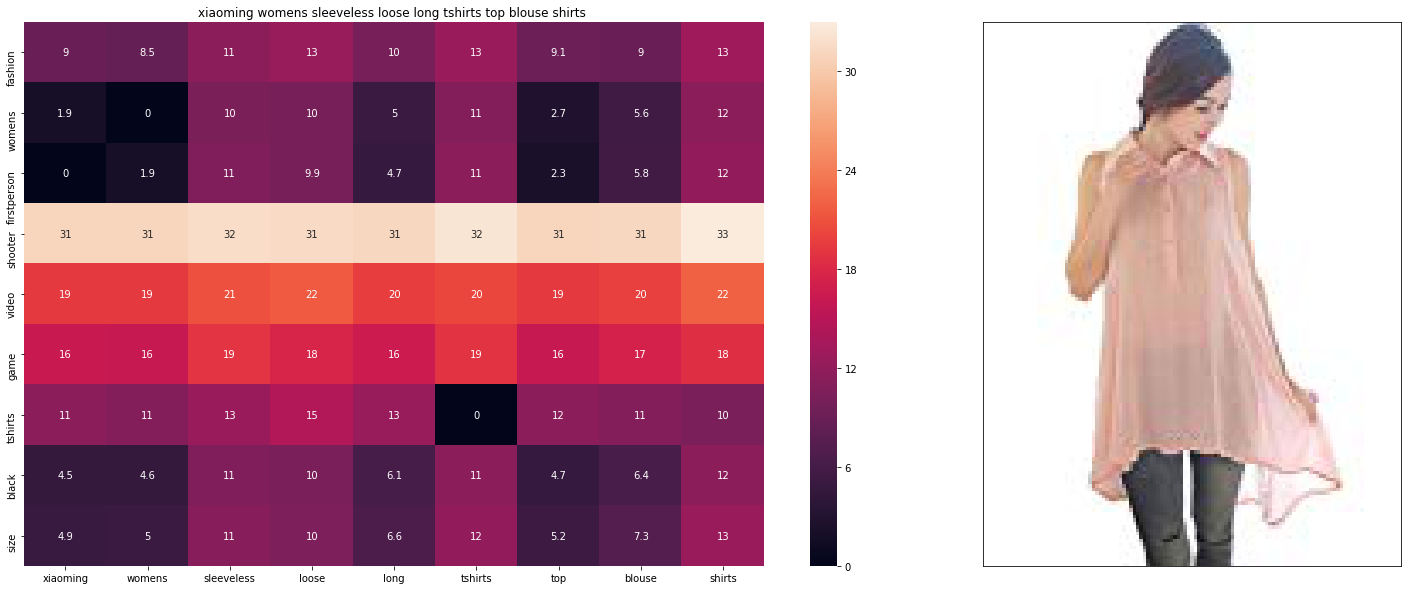

ASIN : B010RV33VE
Brand : xiaoming
euclidean distance from input : 8.685479356760233


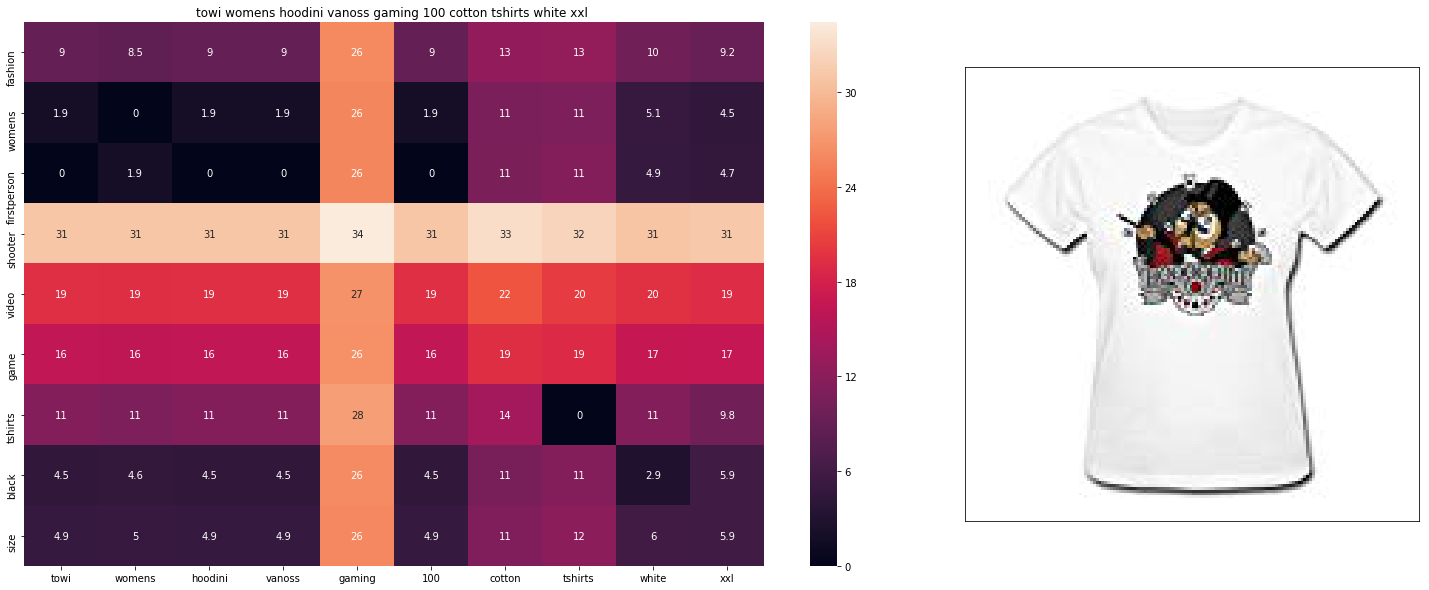

ASIN : B0177LWXGI
Brand : ToWi
euclidean distance from input : 8.746471120828836


In [132]:
def idf_w2v_brand(doc_id, w1, w2,w3,w4, num_results):
    # doc_id: apparel's id in given corpus
    # w1: weight for  w2v features
    # w2: weight for brand and color features

    # pairwise_dist will store the distance from given input apparel to all remaining apparels
    # the metric we used here is cosine, the coside distance is mesured as K(X, Y) = <X, Y> / (||X||*||Y||)
    # http://scikit-learn.org/stable/modules/metrics.html#cosine-similarity
    idf_w2v_dist  = pairwise_distances(w2v_title_weight, w2v_title_weight[doc_id].reshape(1,-1))
    brand_dist = pairwise_distances(extra_features, extra_features[doc_id])
    color_dist = pairwise_distances(extra_features1, extra_features1[doc_id])
    image_dist = pairwise_distances(bottleneck_features_train, bottleneck_features_train[doc_id].reshape(1,-1))
    pairwise_dist   = (w1 * idf_w2v_dist +  w2 *brand_dist +w3*color_dist+ w4*image_dist)/float(w1 + w2+w3+w4)

    # np.argsort will return indices of 20 smallest distances
    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    #pdists will store the 20 smallest distances
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]

    #data frame indices of the 20 smallest distace's
    df_indices = list(data.index[indices])
    
    for i in range(0, len(indices)):
        heat_map_w2v_brand(data['title'].loc[df_indices[0]],data['title'].loc[df_indices[i]], data['medium_image_url'].loc[df_indices[i]], indices[0], indices[i],df_indices[0], df_indices[i], 'weighted')
        print('ASIN :',data['asin'].loc[df_indices[i]])
        print('Brand :',data['brand'].loc[df_indices[i]])
        print('euclidean distance from input :', pdists[i])
        print('='*125)


    

idf_w2v_brand(1000,5,1,1,1,10)